# Cross-Condition Analysis

In [1]:
import sys
!{sys.executable} -m pip install --quiet decoupler liana requests ipywidgets

In [2]:
from pathlib import Path
import os
import requests
import gc

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import partipy as pt
import decoupler as dc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## ParTIpy Analysis of on non-classical Monocytes from Lupus Data - Introduction

Cells of the same type often exhibit a continuum of gene expression states, reflecting their functional diversity and adaptability. The Pareto task optimality theory provides a framework to interpret this variability by organizing cells within a low-dimensional polytope in gene expression space. The vertices of this polytope represent specialized "archetypes"—cells optimized for specific tasks performed by the cell type.

Given this theoretical foundation, archetypal analysis is most meaningful when applied to a single cell type. In this vignette, we focus specifically on **non-classical monocytes** to explore their gene expression patterns and uncover the underlying task specialization from their transcriptional profiles. As algorithm for the archetypal analysis we will use PCHA with random initialization.

## Load Data


In [3]:
data_dir = Path(".") / "data"
data_dir.mkdir(exist_ok=True)

# File URL to download
# 
url = "https://datasets.cellxgene.cziscience.com/4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad"
filename = data_dir / os.path.basename(url)

# Download file if it does not already exist
if not filename.exists():
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    
    print(f"Downloaded: {filename}")
else:
    print(f"File already exists, skipping: {filename}")

File already exists, skipping: data/4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad


In [4]:
adata = sc.read_h5ad(data_dir / "4532eea4-24b7-461a-93f5-fe437ee96f0a.h5ad")
adata.obs["Status"] = adata.obs["disease_state"].map({
    "managed": "Managed",
    "na": "Healthy",
    "flare": "Flare",
    "treated": "Treated"
})
adata = adata[adata.obs["author_cell_type"]=="ncM", :].copy() # only consider non-classical monocytes
adata = adata[adata.obs["Status"] != "Treated", :].copy() # remove samples with "treated" status
# remove columns we don"t need
adata.obs.drop(columns=["mapped_reference_annotation", "cell_type_ontology_term_id", "is_primary_data", 
                        "cell_state", "tissue_ontology_term_id", "development_stage_ontology_term_id", 
                        "tissue", "organism", "tissue_type", "suspension_type", "organism_ontology_term_id",
                        "assay_ontology_term_id", "suspension_enriched_cell_types", "suspension_uuid",
                        "self_reported_ethnicity_ontology_term_id", "disease_ontology_term_id",
                        "sex_ontology_term_id"], 
                        inplace=True)
# create new index
adata.obs.index = [s.split("-")[0] + "-" + str(len(s.split("-"))) + "-" + str(donor_id) 
                   for s, donor_id in zip(adata.obs.index, adata.obs["donor_id"].to_list())]
# remove obsm we don't need
del adata.obsm["X_pca"], adata.obsm["X_umap"], adata.uns
gc.collect()

# use the raw counts
adata.X = adata.raw.X

# use gene symbols instead of ensembl IDs
assert len(adata.var["feature_name"]) == len(adata.var["feature_name"].unique())
adata.var = adata.var.set_index("feature_name")

adata

/Users/pschafer/miniforge3/envs/partipy/lib/python3.11/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009.6', 'ENSG00000239945.1']

    Inferred to be: categorical



AnnData object with n_obs × n_vars = 47819 × 30867
    obs: 'library_uuid', 'author_cell_type', 'sample_uuid', 'disease_state', 'donor_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'assay', 'disease', 'sex', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'Status'
    var: 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'

- Check the number of cells we have per condition

In [5]:
adata.obs.value_counts("Status")

Status
Managed    31268
Healthy    15091
Flare       1460
Name: count, dtype: int64

## Quality Control

We follow the Scanpy [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html) to perform quality control on our dataset
We first compute the proportion of counts originating from mitochondrial, ribosomal, and hemoglobin genes:

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

We can now examine key quality control metrics, including:
- The number of genes expressed per cell
- The total counts per cell
- The percentage of counts originating from mitochondrial genes

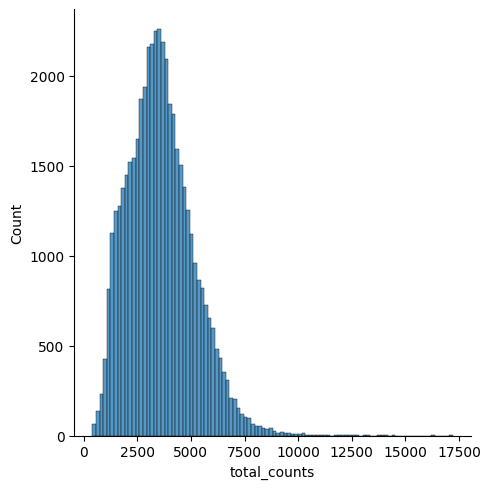

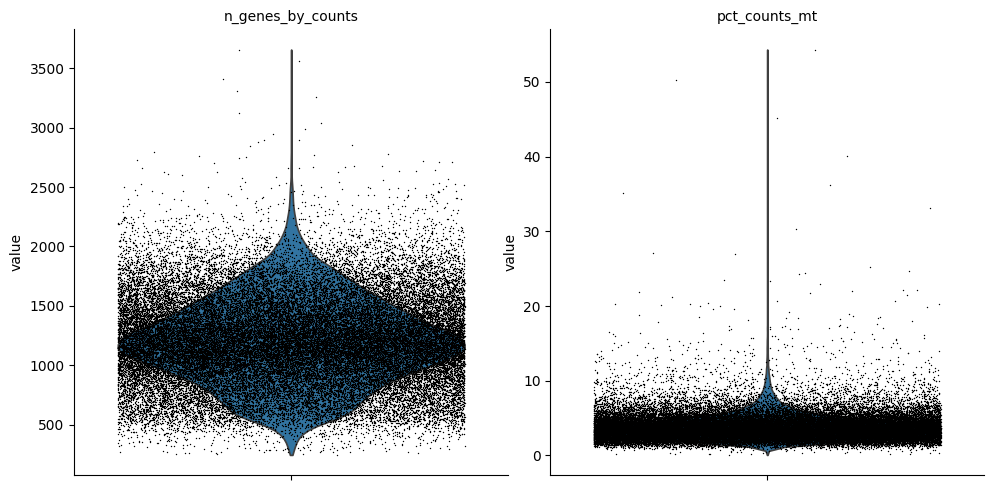

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

To remove low-quality data, we filter out cells with fewer than 100 detected genes and genes that are present in fewer than 3 cells. This ensures that only high-quality cells and genes are retained for downstream analysis.

In [9]:
print(f"Number of cells before filtering: {adata.n_obs} \nNumber of genes before filtering: {adata.n_vars}")
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of cells after filtering of low quality cells: {adata.n_obs} \nNumber of genes after filtering of low quality genes: {adata.n_vars}")

Number of cells before filtering: 47819 
Number of genes before filtering: 30867
Number of cells after filtering of low quality cells: 47819 
Number of genes after filtering of low quality genes: 18496


## Normalization and feature selection

To ensure comparability across cells, we normalize the data to the median total counts per cell and apply a logarithmic transformation:

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

ANext, we identify highly variable genes, which are key for downstream analysis. We also visualize them to assess their distribution:

In [11]:
sc.pp.highly_variable_genes(adata)

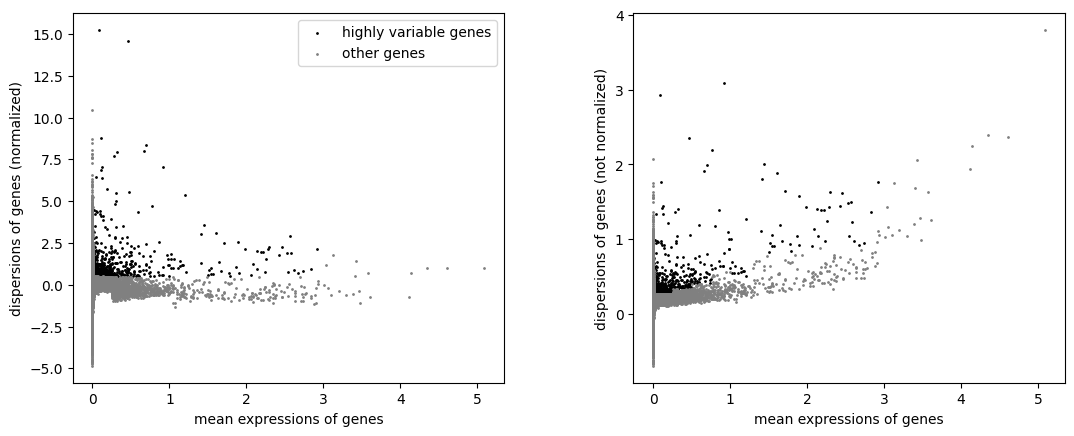

In [12]:
sc.pl.highly_variable_genes(adata)

For downstream enrichment analysis, we standardize the data by scaling gene expression values:

In [13]:
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10)

## Dimension Reduction

We compute Principal Component Analysis (PCA) using only highly variable genes and visualize the results:

In [14]:
adata.obs

library_uuid  \
GGAGCAAAGTCCAGGA-21-IGTB195  f1568b25-4a87-414f-8329-1a860a3a8aeb   
AATCCAGCAAATCCGT-27-1772     7c76a618-92ba-41fd-b0a7-306a1c1a6bf2   
AAGCCGCAGTGAAGTT-79-HC-540   ecd9109f-7197-46df-b3a8-1ac2d9990185   
GTCACAAAGTACACCT-51-IGTB498  d49aa545-2b96-409c-85e8-2bf8706475fb   
TAAGAGACAGGTGCCT-87-1772     1e3165e4-e0c0-4bf7-b803-7d8271b99fd5   
...                                                           ...   
CCTTACGGTAATCACC-97-1667     10cec51f-a79f-4907-8745-b45df64f6946   
CAGGTGCAGGGAAACA-55-1110     3044f2b9-48b5-45ec-ac14-107f0d7372f0   
CACACCTAGGCGATAC-56-1056     b795713b-ff23-4494-b6a3-1438b2baee3e   
ATAAGAGAGATCGATA-92-HC-578   16552c24-ef48-4e1f-aff5-319a1f739299   
GAATGAACACCGGAAA-73-HC-554   1495b93b-a19f-4364-95a3-6d8ac531eac6   

                            author_cell_type  \
GGAGCAAAGTCCAGGA-21-IGTB195              ncM   
AATCCAGCAAATCCGT-27-1772                 ncM   
AAGCCGCAGTGAAGTT-79-HC-540               ncM   
GTCACAAAGTACACCT-51-IGTB498              ncM   
TAAGAGACAGGTGCCT-87-1772                 ncM   
...                                      ...   
CCTTACGGTAATCACC-97-1667                 ncM   
CAGGTGCAGGGAAACA-55-1110                 ncM   
CACACCTAGGCGATAC-56-1056                 ncM   
ATAAGAGAGATCGATA-92-HC-578               ncM   
GAATGAACACCGGAAA-73-HC-554               ncM   

                                                      sample_uuid  \
GGAGCAAAGTCCAGGA-21-IGTB195  f0a33a73-192b-4398-b8bc-05eb0c59ae54   
AATCCAGCAAATCCGT-27-1772     a17b2b7f-ab2c-47b0-bb6f-257e8d2fa4c9   
AAGCCGCAGTGAAGTT-79-HC-540   bc16e1fe-cd25-4a6b-a329-2e2c7121ad8d   
GTCACAAAGTACACCT-51-IGTB498  3672d82d-f24c-4536-b75a-0627889e1426   
TAAGAGACAGGTGCCT-87-1772     3178b123-e965-4449-8944-c88b17d0d082   
...                                                           ...   
CCTTACGGTAATCACC-97-1667     ccccc606-2c86-4d7a-bb4a-8354017807a6   
CAGGTGCAGGGAAACA-55-1110     5e0ed28c-a75a-4ecd-a0c7-49e71264690b   
CACACCTAGGCGATAC-56-1056     9198675e-be82-472f-b352-a98629c9876a   
ATAAGAGAGATCGATA-92-HC-578   37d3daeb-c0f5-414a-8b98-0517e7464535   
GAATGAACACCGGAAA-73-HC-554   55555033-33d9-49bc-b378-c20c8ed2fb1b   

                            disease_state donor_id Processing_Cohort ct_cov  \
GGAGCAAAGTCCAGGA-21-IGTB195            na  IGTB195               1.0    NaN   
AATCCAGCAAATCCGT-27-1772            flare     1772               3.0    NaN   
AAGCCGCAGTGAAGTT-79-HC-540             na   HC-540               4.0    NaN   
GTCACAAAGTACACCT-51-IGTB498            na  IGTB498               2.0    NaN   
TAAGAGACAGGTGCCT-87-1772          managed     1772               4.0    NaN   
...                                   ...      ...               ...    ...   
CCTTACGGTAATCACC-97-1667          managed     1667               4.0    NaN   
CAGGTGCAGGGAAACA-55-1110          managed     1110               2.0    NaN   
CACACCTAGGCGATAC-56-1056          managed     1056               2.0    NaN   
ATAAGAGAGATCGATA-92-HC-578             na   HC-578               4.0    NaN   
GAATGAACACCGGAAA-73-HC-554             na   HC-554               4.0    NaN   

                                     ind_cov               cell_type  \
GGAGCAAAGTCCAGGA-21-IGTB195  IGTB195_IGTB195  non-classical monocyte   
AATCCAGCAAATCCGT-27-1772           1772_1772  non-classical monocyte   
AAGCCGCAGTGAAGTT-79-HC-540            HC-540  non-classical monocyte   
GTCACAAAGTACACCT-51-IGTB498  IGTB498_IGTB498  non-classical monocyte   
TAAGAGACAGGTGCCT-87-1772           1772_1772  non-classical monocyte   
...                                      ...                     ...   
CCTTACGGTAATCACC-97-1667           1667_1667  non-classical monocyte   
CAGGTGCAGGGAAACA-55-1110           1110_1110  non-classical monocyte   
CACACCTAGGCGATAC-56-1056           1056_1056  non-classical monocyte   
ATAAGAGAGATCGATA-92-HC-578            HC-578  non-classical monocyte   
GAATGAACACCGGAAA-73-HC-554            HC-554  non-classical monocyte   

    

In [15]:
adata.obs.value_counts("Status")

Status
Managed    31268
Healthy    15091
Flare       1460
Name: count, dtype: int64

In [16]:
sc.pp.pca(adata, mask_var="highly_variable")

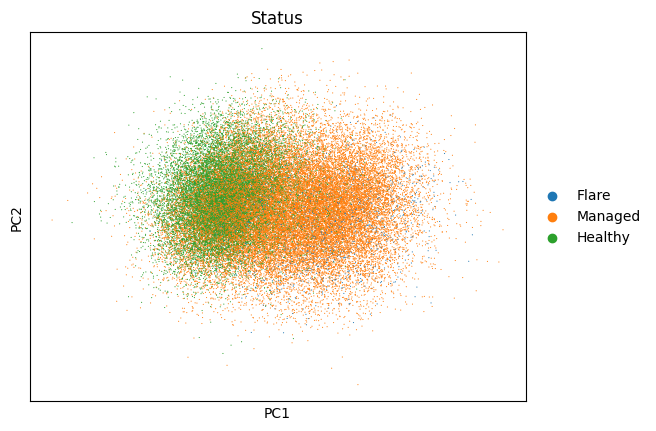

In [17]:
sc.pl.pca_scatter(adata, color="Status")

To determine the optimal number of principal components (PCs) to retain, we inspect their contribution to the total variance:

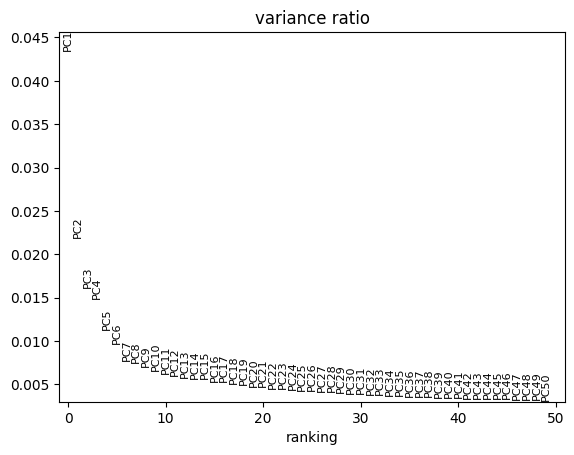

In [18]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)

Based on this, we select 7 PCs, as the variance explained plateaus beyond this point.

In [19]:
n_pcs = 7

For ease of use in downstream analysis, we store the number of dimensions in adata.uns["n_pcs"] with the following function:

In [20]:
pt.set_dimension_aa(adata=adata, n_pcs=n_pcs)

## Number of Archetypes

Next, we need to determine the optimal number of archetypes in our data—essentially, the number of vertices in the polyhedron.

We first assess how much variance is explained for different numbers of archetypes.

The function var_explained_aa() takes the reduced PCA data and calculates the explained variance for a range of archetypes (min_a to max_a). Additionally, it computes:

- The variance explained by each archetype.
- The additional variance explained by each successive archetype.
- The distance from the projected point to the line of the elbow plot.

In [21]:
pt.var_explained_aa(adata=adata, min_a=2, max_a=10)

The results are stored in:

In [22]:
adata.uns["AA_var"]

k   varexpl  varexpl_ontop  dist_to_projected
0   2  0.346434       0.346434           0.000000
1   3  0.515949       0.169515           0.099970
2   4  0.624980       0.109031           0.139600
3   5  0.715667       0.090687           0.160931
4   6  0.780442       0.064775           0.156411
5   7  0.836827       0.056385           0.143521
6   8  0.869374       0.032547           0.106851
7   9  0.887793       0.018419           0.056086
8  10  0.900878       0.013084           0.000000

We visualize the explained variance for different models:

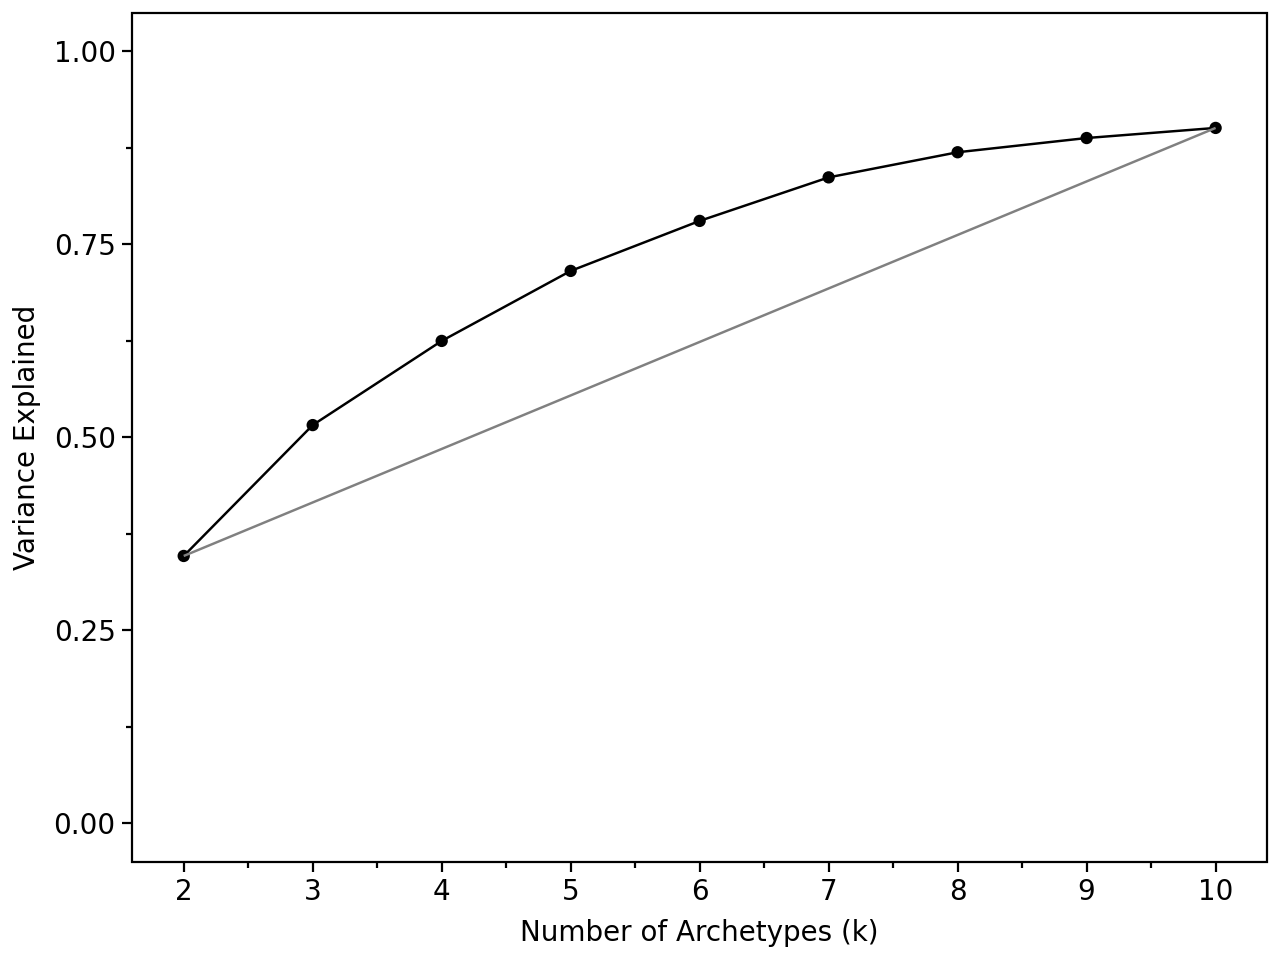

In [23]:
pt.plot_var_explained(adata)

In this plot, the grey line connects the first and last variance explained (EV) values, helping to identify the "elbow" of the black curve.

This analysis suggests that the best choice is 4-6 archetypes. We decide to use 4 archetypes, as later analyses show that the 5th archetype introduces no new tasks.

In [24]:
n_archetypes = 4

To validate the archetype stability, we apply bootstrapping. We sample the data five times (for efficiency) and run Archetypal Analysis (AA) on each sample. 

In [25]:
pt.bootstrap_aa(adata=adata, n_bootstrap=20, n_archetypes=n_archetypes)

The positions of the archetypes and the mean variance across all bootstrapped samples are stored in:

In [26]:
adata.uns["AA_bootstrap"]

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0  -2.668890  4.088350  3.711213 -0.845698  0.044367 -0.068307  0.448207   
1   1.728620  3.460316 -4.051245  0.558748  0.449326 -0.160270 -0.275335   
2   5.924196 -2.183953  1.201705  0.068279 -0.275643 -0.042351  0.059097   
3  -4.704533 -3.758228 -0.767592  0.110385 -0.187961  0.021108 -0.086036   
0  -4.592047  2.553077  3.936700  3.524402 -0.627596 -0.515674  0.602601   
..       ...       ...       ...       ...       ...       ...       ...   
3  -4.383441 -3.809741 -1.304468  0.248364 -0.156855 -0.099316 -0.181350   
0  -2.069577  4.268209  3.629548 -1.002551  0.057755 -0.149205  0.335735   
1   0.770125  3.211378 -4.173791  0.930805  0.283522  0.016598 -0.387046   
2   6.289063 -1.945523  0.783505  0.104504 -0.321800 -0.193616  0.146081   
3  -4.614166 -3.777621 -0.287736 -0.044557  0.031959  0.095499 -0.039061   

   archetype  iter  reference  mean_variance  
0          0     1      False       0.261487  
1          1     1      False       0.261487  
2          2     1      False       0.261487  
3          3     1      False       0.261487  
0          0     2      False       0.261487  
..       ...   ...        ...            ...  
3          3    20      False       0.261487  
0          0     0       True       0.261487  
1          1     0       True       0.261487  
2          2     0       True       0.261487  
3          3     0       True       0.261487  

[84 rows x 11 columns]

We visualize the bootstrapping results:

In [27]:
pt.plot_bootstrap_3D(adata)

The results show that the archetypes are mostly stable, supporting our selection. 

## Archetype Analysis and visualization

Now that we've determined the number of archetypes, we can compute the four archetypes and save them to our AnnData object:

In [28]:
pt.compute_archetypes(adata, n_archetypes, init="furthest_sum", max_iter=300, verbose=True, archetypes_only=False)

Algorithm converged after 280 iterations.


The results including the archetypes are stored here

In [29]:
adata.uns["archetypal_analysis"]["Z"]

array([[-2.87546825e+00,  3.81681752e+00,  3.83019662e+00,
        -8.25595498e-01,  6.94735423e-02, -5.59272012e-03,
         5.08078635e-01],
       [ 1.95461190e+00,  3.62053394e+00, -3.90752101e+00,
         5.13224125e-01,  2.99303949e-01, -1.32052928e-01,
        -4.09290284e-01],
       [ 6.04989862e+00, -2.16095972e+00,  1.29576278e+00,
         1.11714475e-01, -2.24647760e-01, -1.30440712e-01,
         1.59062386e-01],
       [-4.59943438e+00, -3.73855162e+00, -9.60166812e-01,
         1.45793810e-01, -1.43464431e-01,  1.86082069e-02,
        -1.54826775e-01]], dtype=float32)

We can check for the convergence here

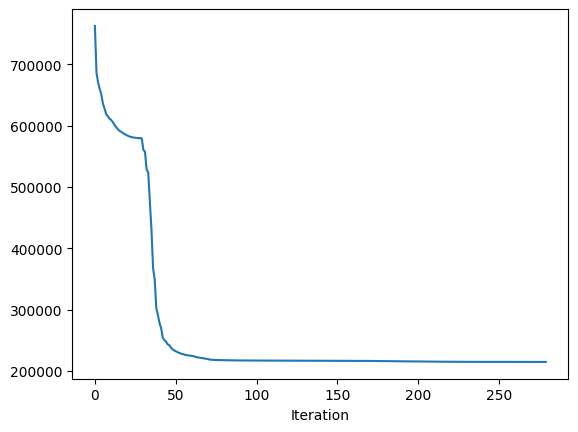

In [30]:
plt.plot(adata.uns["archetypal_analysis"]["RSS"])
plt.xlabel("Iteration", y="Residual Sum of Squares (RSS)")
plt.show()

We can visualize the polytope in both 2D and 3D. We want the colors to represent the disease status.
Alternatively, we can color the plot based on a gene with distinct expression across archetypes. For example, using the gene IFI27.

We visualize the polytope in 2D with the following:

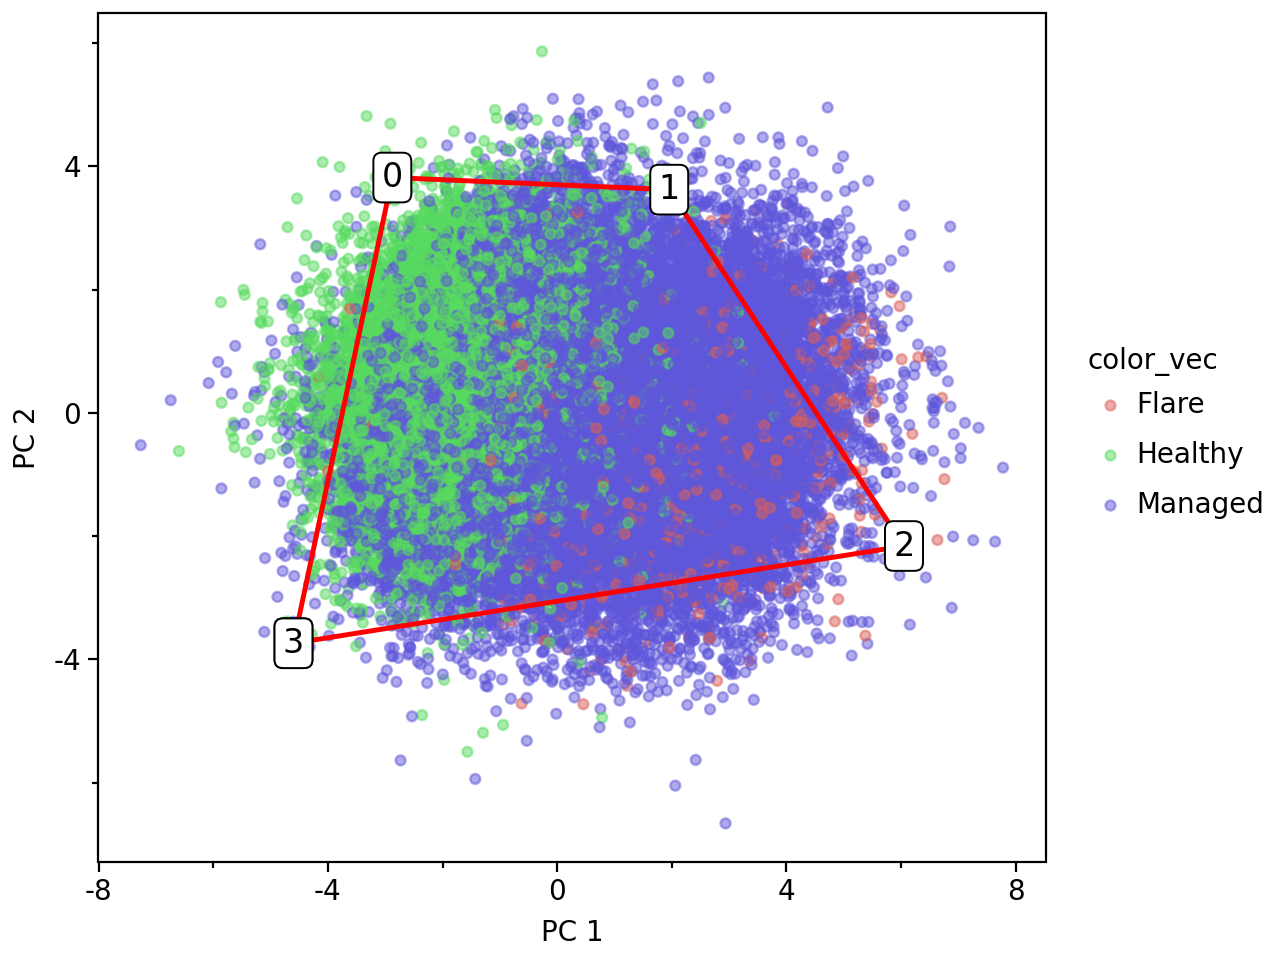

In [31]:
pt.plot_archetypes_2D(adata=adata, color="Status")

For a 3D representation, we can plot the data along with the archetypes in a 3D space. You may choose to subset the data if necessary:

In [32]:
pt.plot_archetypes_3D(adata=adata, color="Status")

## Identify representatives

To assign tasks to the archetypes, we need to identify cells that are representative of each archetype. To do this, we calculate a weighted pseudobulk for each archetype.

First, we calculate the weights for each cell based on its distance from the archetypes. The length scale of the RBF kernel is automatically set as half the median distance from the data centroid to the archetypes. However, this can also be manually adjusted if needed:

In [33]:
pt.compute_archetype_weights(X=adata, mode="automatic")

Applied length scale is 3.052721083083717.


We can visualize the cell weights for each archetype to assess their distribution:

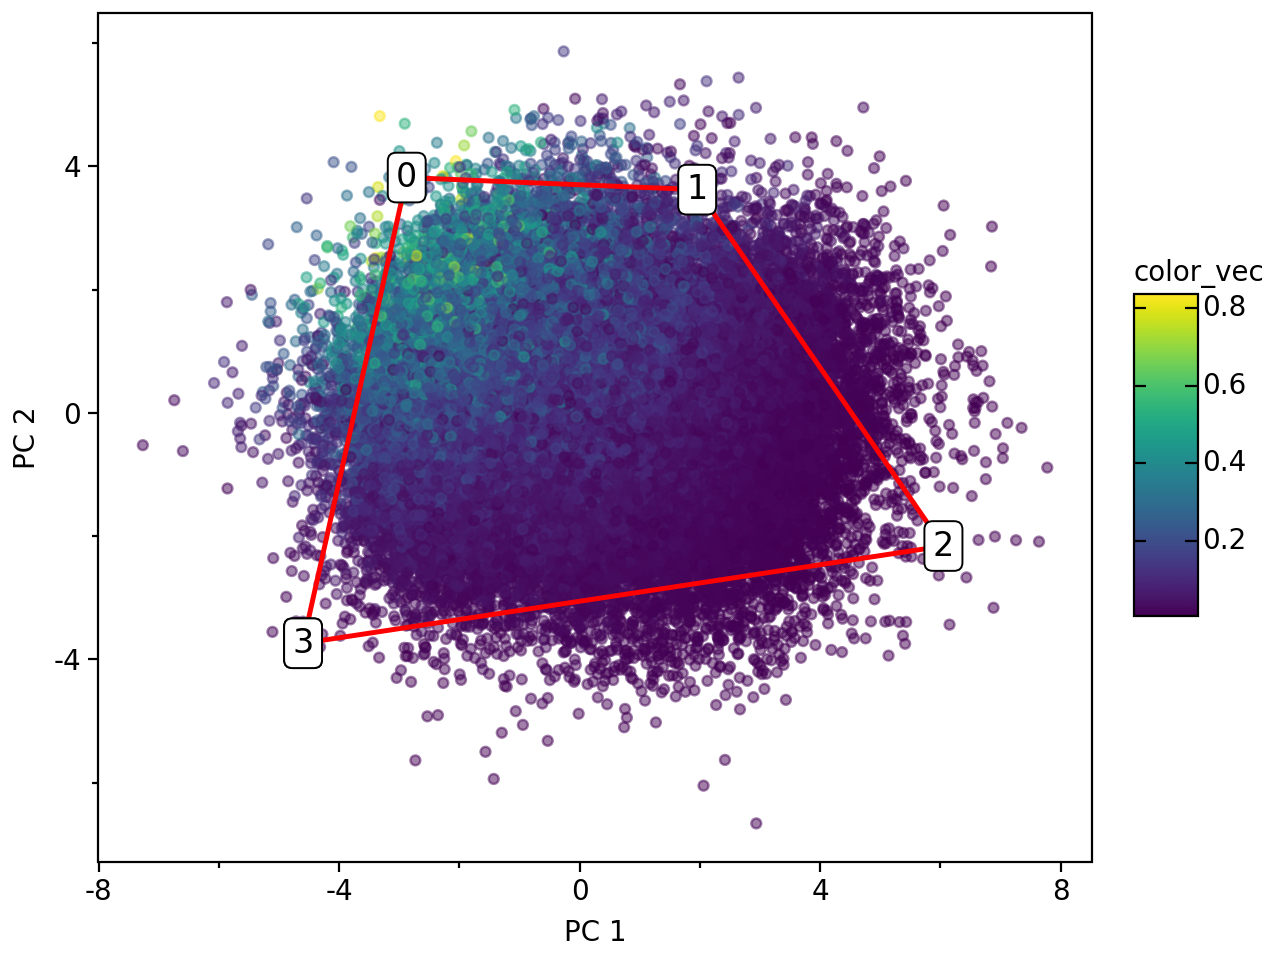

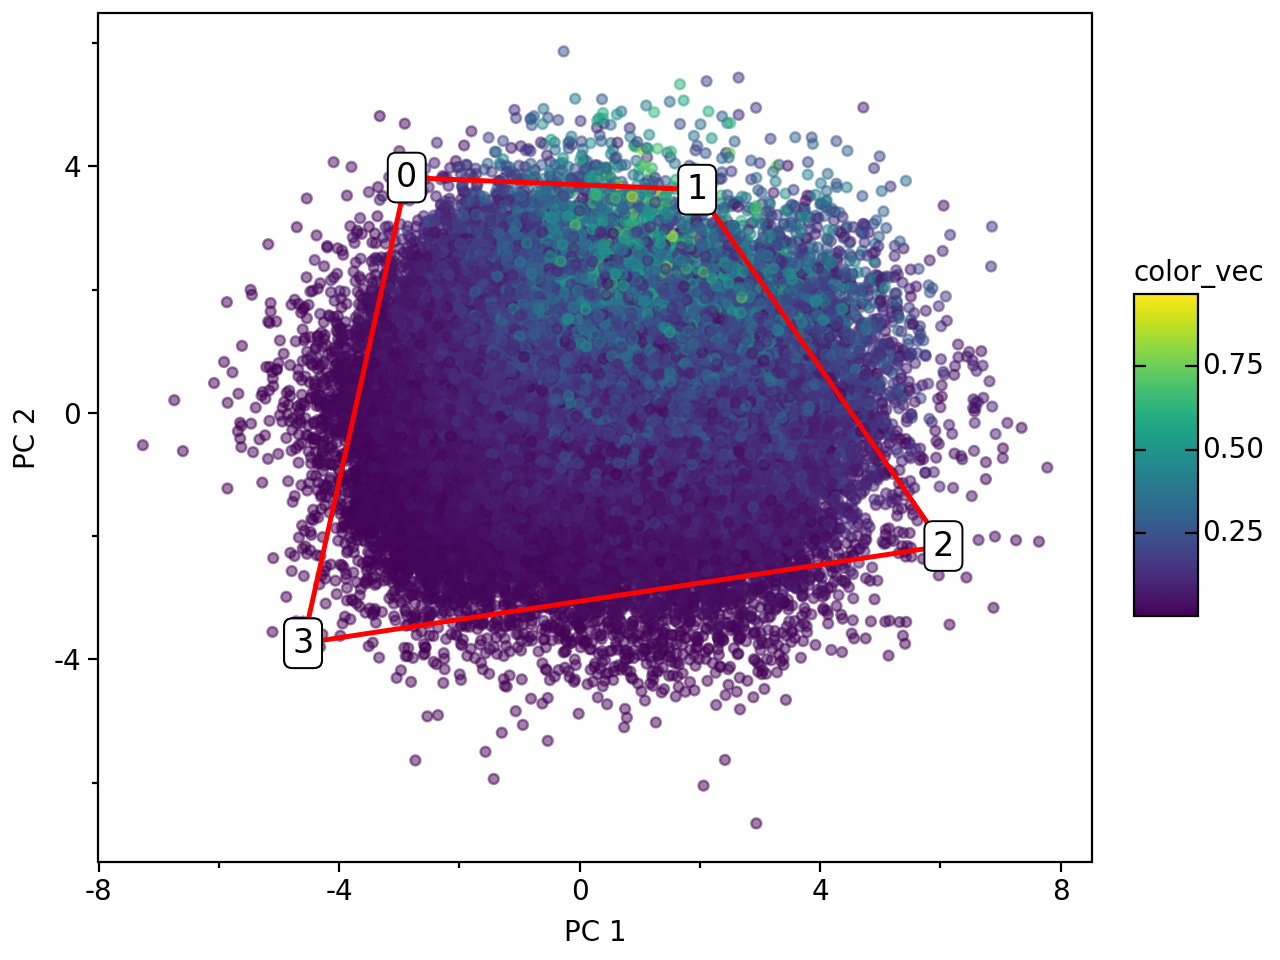

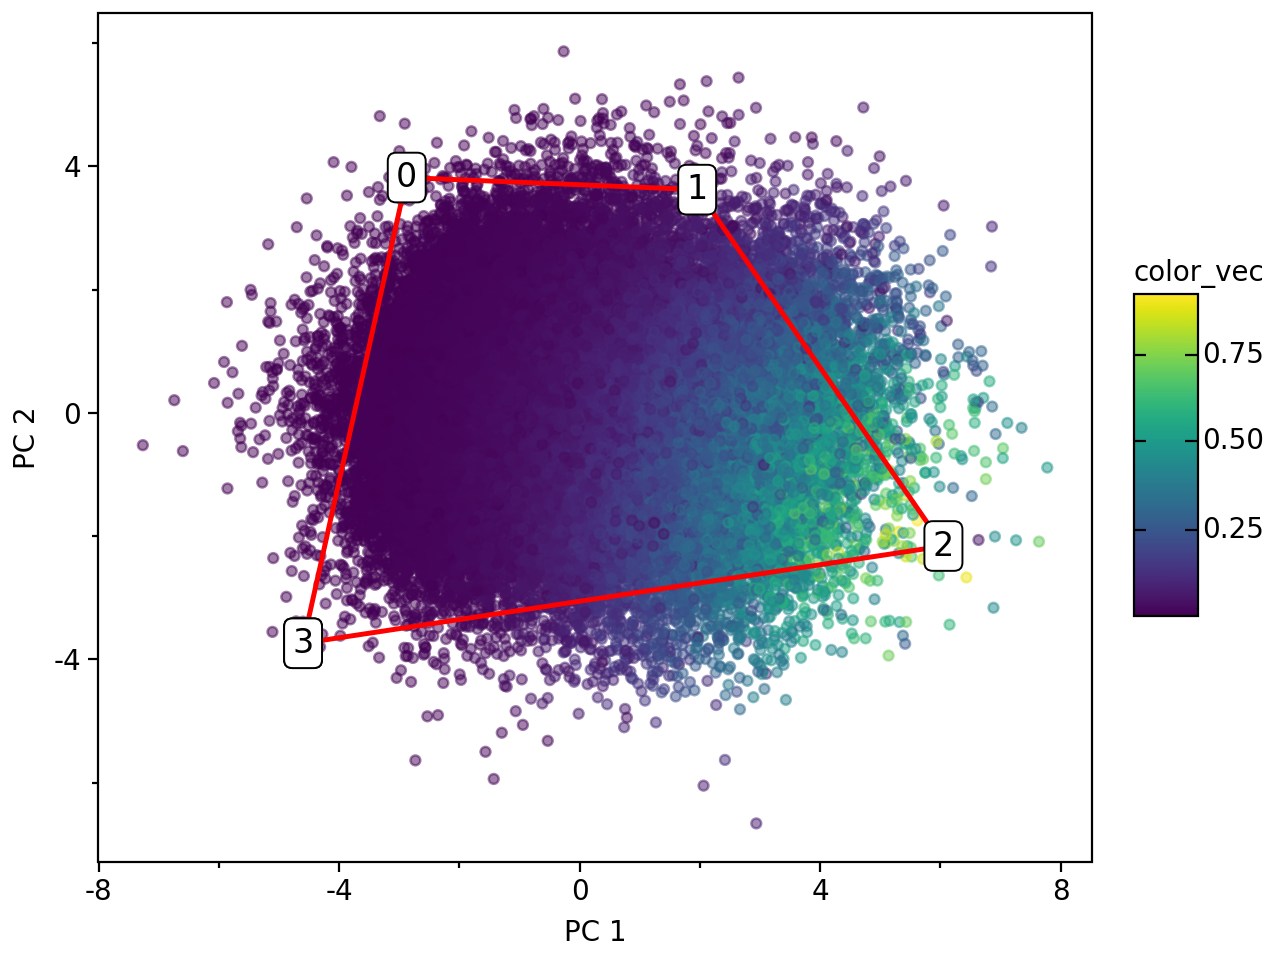

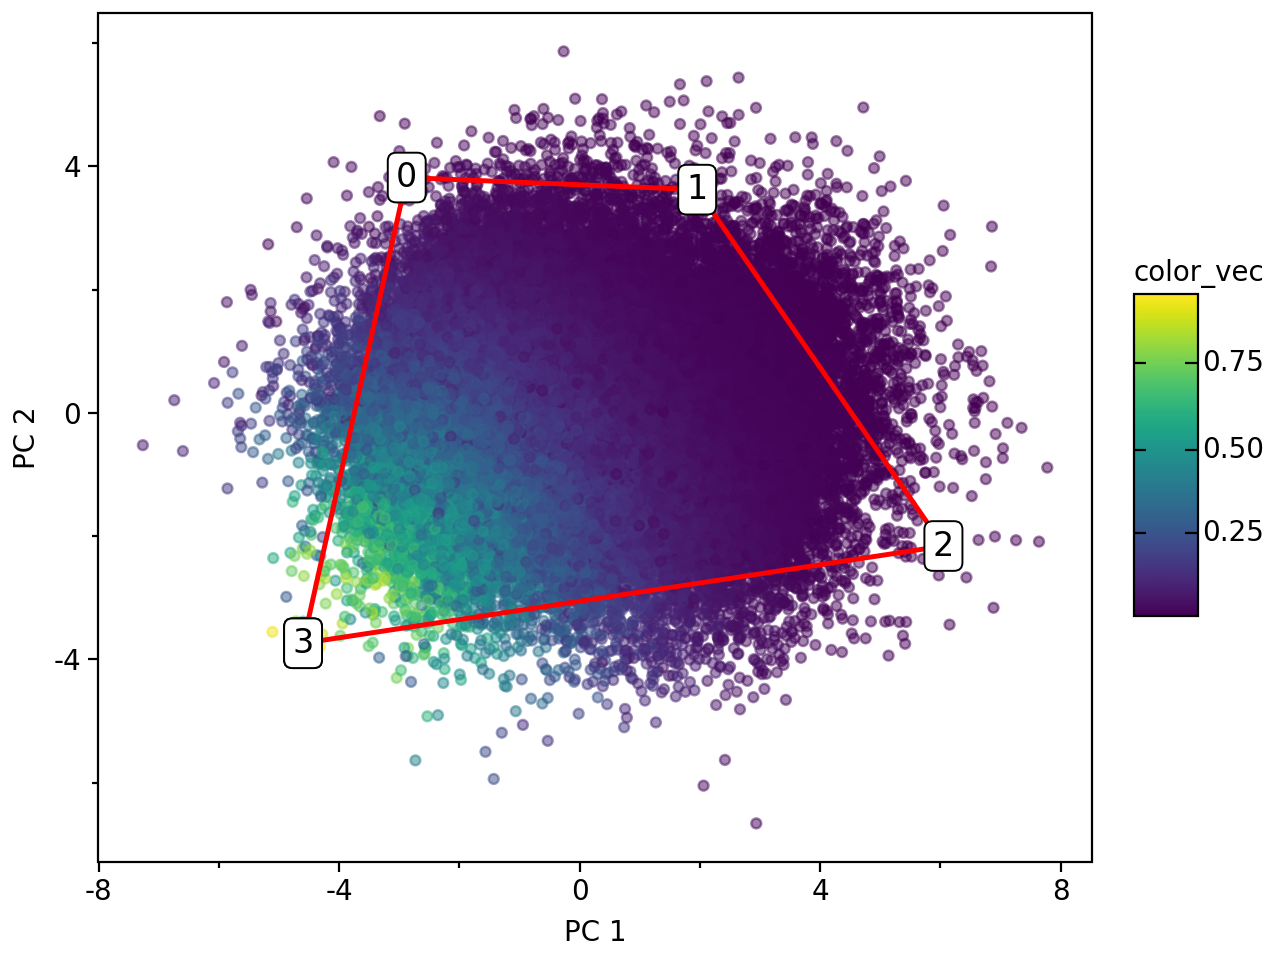

In [34]:
for i in range(0,4):
    plt = pt.plot_2D(adata.obsm["X_pca"], Z = adata.uns["archetypal_analysis"]["Z"], color_vec=adata.obsm["cell_weights"].T[i])
    plt.show()

## Enrichment Metadata

With the weights we can now calculate enrichment of interest. Since we have different cell status associated with healthy and disease, we want first to check the enrichment by the "disease_state and find our archetypes of interest.

meta_enrichment() calcualtes the enrichment of any specified metadata stored in obs. 

In [35]:
status_enrichment = pt.compute_meta_enrichment(adata=adata, meta_col="Status")
status_enrichment

Flare   Managed   Healthy
0  0.142856  0.314229  0.542914
1  0.349500  0.332276  0.318224
2  0.564674  0.360398  0.074928
3  0.202848  0.287807  0.509345

We find ncM with the "Flare" status enriched at archetype 2 and not associated with archetype 0. We can observe such distribution in the PCA space when plotting only the ncM with "Flare" status: 

In [36]:
pt.plot_archetypes_3D(adata, color="Status")

We can also visualize the results like this:

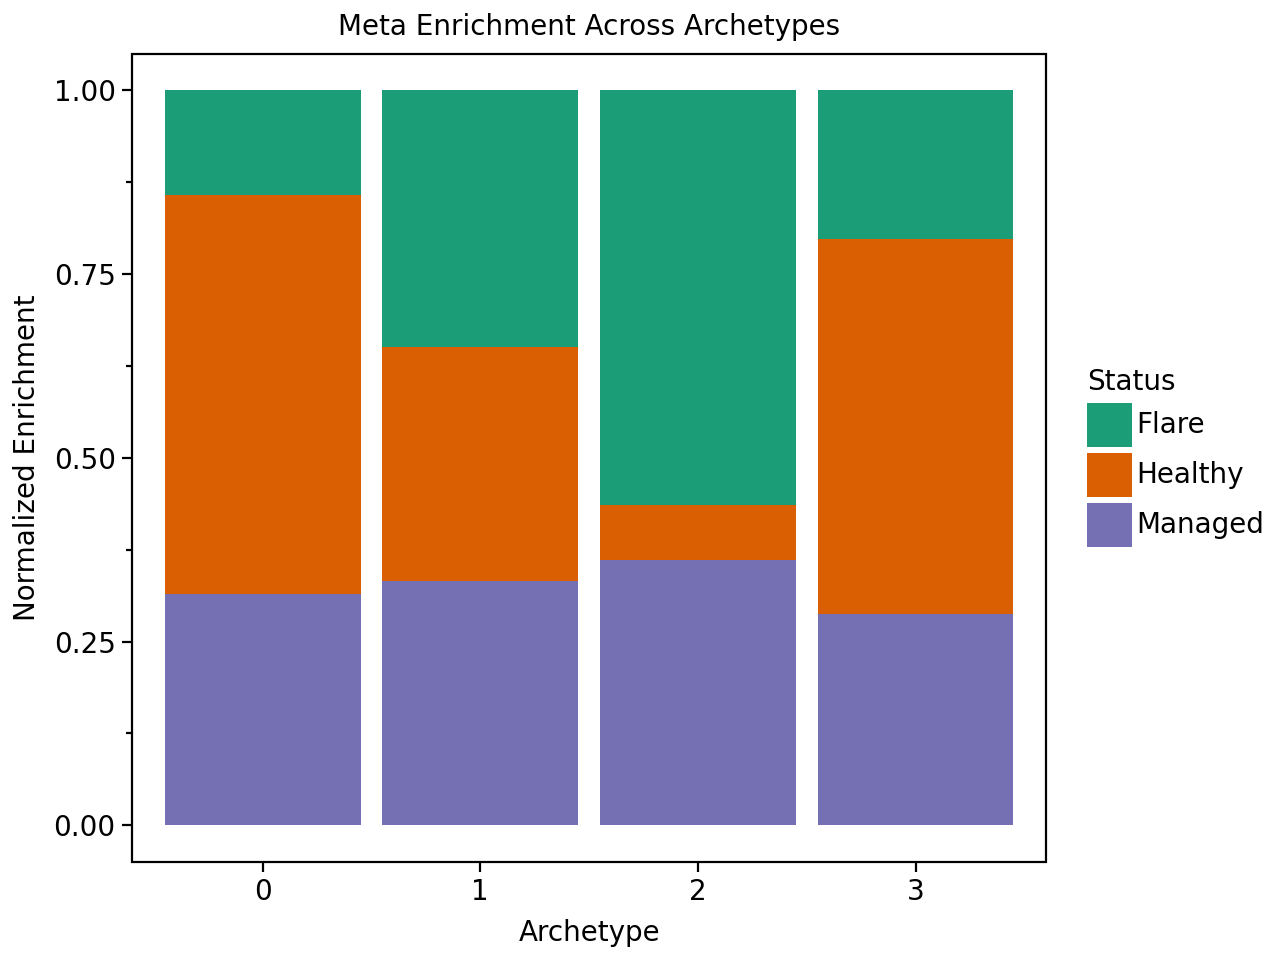

In [37]:
pt.barplot_meta_enrichment(status_enrichment, meta="Status")

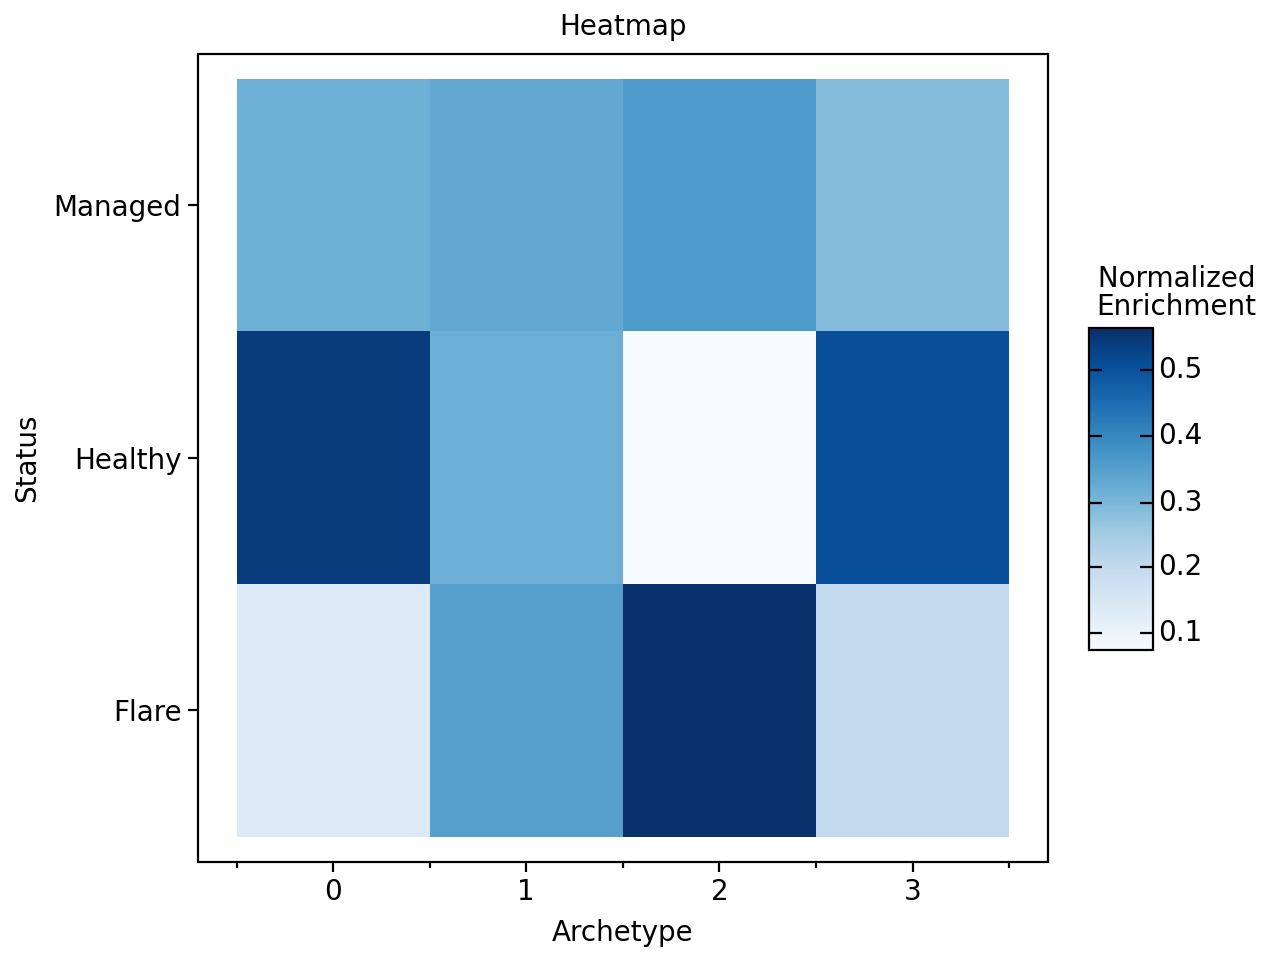

In [38]:
pt.heatmap_meta_enrichment(status_enrichment, meta="Status")

## Functional Enrichment MSigDB

Next, we compute a pseudobulk using the z-scaled gene expression data to observe differences in gene expression across the archetypes:

In [39]:
archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")
archetype_expression.iloc[:, 20:25]

TNFRSF4      SDF4   B3GALT6  C1QTNF12  ENSG00000260179.1
0 -0.008245  0.012280 -0.000208 -0.018446          -0.017360
1 -0.015835  0.004448 -0.005670 -0.019760          -0.019101
2 -0.022070  0.028431 -0.007929 -0.024059          -0.020295
3 -0.014828 -0.025647 -0.011950 -0.024687          -0.022887

For functional enrichment, we use Decoupler with Gene Ontology (GO) biological processes. While other collections can be used, it’s recommended to choose those with less broad categories to avoid non-significant results.

We begin by loading the MSigDB resource and filtering for the GO biological processes collection:

In [40]:
msigdb_raw = dc.get_resource("MSigDB")
msigdb = msigdb_raw[msigdb_raw["collection"]=="go_biological_process"]
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])]

Next, we run ULM on the pseudobulk data using the filtered MSigDB resource. The results are saved in acts_ulm_est and acts_ulm_est_p:

In [41]:
acts_ulm_est_msigdb, acts_ulm_est_p_msigdb = dc.run_ulm(mat = archetype_expression,
                                                        net = msigdb,
                                                        weight = None,
                                                        source="geneset",
                                                        target="genesymbol")

acts_ulm_est_msigdb

GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS  \
0                                         -0.217125   
1                                          0.398411   
2                                          0.198489   
3                                          0.140904   

   GOBP_2FE_2S_CLUSTER_ASSEMBLY  GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS  \
0                     -1.297645                              -0.303589   
1                      2.744519                               1.605643   
2                      1.465637                               0.858246   
3                      0.172862                              -0.231261   

   GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS  \
0                                          -0.749641            
1                                           0.984184            
2                                           0.547093            
3                                          -0.494100            

   GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION  \
0                                  5.905128   
1                                  1.358077   
2                                  0.034360   
3                                 -3.697138   

   GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION  GOBP_4FE_4S_CLUSTER_ASSEMBLY  \
0                                4.878520                     -0.584698   
1                                1.809647                      1.444152   
2                                0.484594                      0.901747   
3                               -2.449372                      0.574863   

   GOBP_5S_CLASS_RRNA_TRANSCRIPTION_BY_RNA_POLYMERASE_III  \
0                                           0.408884        
1                                           0.895256        
2                                           0.394401        
3                                           0.358929        

   GOBP_5_PHOSPHORIBOSE_1_DIPHOSPHATE_METABOLIC_PROCESS  \
0                                           0.220608      
1                                           1.628075      
2                                           0.547002      
3                                           0.153673      

   GOBP_7_METHYLGUANOSINE_CAP_HYPERMETHYLATION  ...  \
0                                    -2.102138  ...   
1                                     2.963455  ...   
2                                     2.601383  ...   
3                                     0.358633  ...   

   GOBP_XENOBIOTIC_TRANSPORT  \
0                  -0.925362   
1                  -1.102064   
2                  -0.919310   
3                  -0.194290   

   GOBP_XENOBIOTIC_TRANSPORT_ACROSS_BLOOD_BRAIN_BARRIER  GOBP_XENOPHAGY  \
0                                          -0.129362           1.364264   
1                                          -0.451311           1.583010   
2                                          -0.612929           2.177417   
3                                           0.332172          -2.834070   

   GOBP_XMP_METABOLIC_PROCESS  GOBP_XYLULOSE_5_PHOSPHATE_METABOLIC_PROCESS  \
0                    0.565738                                    -0.942393   
1                    1.995254                                     2.505968   
2                   -0.302271                                     0.767156   
3                   -0.074103                                    -0.466543   

   GOBP_ZINC_ION_IMPORT_ACROSS_PLASMA_MEMBRANE  \
0                                     0.435846   
1                                     0.591025   
2                                    -0.170447   
3                                     0.328611   

   GOBP_ZINC_ION_IMPORT_INTO_ORGANELLE  GOBP_ZINC_ION_TRANSPORT  \
0                             0.190876                 0.237179   
1                             0.221715                 0.663114   
2                             0.117222                 0.216274   
3                             0.456128                 0.743216   

   GOBP_ZYMOGEN_ACTIVATIO

To identify the top enriched processes for each archetype, we extract the top n processes and order them in descending order:

In [42]:
top_processes_msigdb = pt.extract_enriched_processes(est=acts_ulm_est_msigdb, 
                                                     pval=acts_ulm_est_p_msigdb, 
                                                     order="desc", 
                                                     n=20, 
                                                     p_threshold=0.05)

We can access them using the keys in the form of "archetype_X". For example, for archetype 2, which is enriched in “Flare,” we observe an enrichment of processes related to the immune response to viruses and the response to interferon.

In [43]:
top_processes_msigdb[2].round(2)

Process      0      1  \
0   GOBP_NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLI... -13.80  -0.86   
1           GOBP_NEGATIVE_REGULATION_OF_VIRAL_PROCESS -11.96   2.26   
2                   GOBP_DEFENSE_RESPONSE_TO_SYMBIONT  -8.10   3.69   
3             GOBP_DEFENSE_RESPONSE_TO_OTHER_ORGANISM  -3.58  12.67   
4                         GOBP_INNATE_IMMUNE_RESPONSE  -4.41  11.49   
5   GOBP_BIOLOGICAL_PROCESS_INVOLVED_IN_INTERSPECI...  -0.79  14.72   
6                              GOBP_RESPONSE_TO_VIRUS  -5.53   5.66   
7                               GOBP_DEFENSE_RESPONSE  -1.77  13.74   
8                                GOBP_IMMUNE_RESPONSE  -1.60  15.63   
9                    GOBP_REGULATION_OF_VIRAL_PROCESS  -7.42   6.60   
10        GOBP_REGULATION_OF_VIRAL_GENOME_REPLICATION  -7.42   0.32   
11                 GOBP_RESPONSE_TO_TYPE_I_INTERFERON  -8.09  -0.76   
12                   GOBP_RESPONSE_TO_INTERFERON_BETA -10.98   1.75   
13                      GOBP_VIRAL_GENOME_REPLICATION  -4.38   2.02   
14         GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY  -6.54   0.24   
15                              GOBP_VIRAL_LIFE_CYCLE  -4.27   6.96   
16                                 GOBP_VIRAL_PROCESS  -0.97   7.88   
17                 GOBP_REGULATION_OF_IMMUNE_RESPONSE   0.12  13.64   
18     GOBP_REGULATION_OF_RESPONSE_TO_BIOTIC_STIMULUS  -0.06   8.23   
19       GOBP_NEGATIVE_REGULATION_OF_VIRAL_LIFE_CYCLE  -8.97   3.11   

            2          3  specificity  
0   28.820000 -19.120001    29.680000  
1   28.180000 -21.309999    25.920000  
2   26.790001 -19.900000    23.100000  
3   26.200001 -24.049999    13.520000  
4   25.920000 -22.639999    14.430000  
5   25.549999 -24.540001    10.840000  
6   25.120001 -19.490000    19.459999  
7   24.480000 -24.799999    10.740000  
8   23.760000 -24.719999     8.130000  
9   23.360001 -20.549999    16.770000  
10  22.580000 -16.309999    22.260000  
11  21.730000 -14.260000    22.490000  
12  20.350000 -14.170000    18.600000  
13  19.260000 -13.810000    17.240000  
14  18.830000 -12.820000    18.580000  
15  18.650000 -15.930000    11.690000  
16  17.670000 -15.020000     9.790000  
17  17.360001 -18.990000     3.720000  
18  17.150000 -16.100000     8.920000  
19  17.110001 -13.830000    14.000000

On the other hand, archetype 3 seems to represent the task of upkeeping homeostasis and normal cellular function in the cells.

In [44]:
top_processes_msigdb[3].round(2)

Process          0          1  \
0                        GOBP_CYTOPLASMIC_TRANSLATION  25.700001  35.459999   
1                                 GOBP_RNA_PROCESSING  12.350000  10.480000   
2   GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_CYTOCHRO...   2.390000   4.440000   
3   GOBP_POSITIVE_REGULATION_OF_ATP_BIOSYNTHETIC_P...   1.220000  -0.250000   
4       GOBP_POSITIVE_REGULATION_OF_RESPIRATORY_BURST   0.360000  -2.390000   
5   GOBP_POSITIVE_REGULATION_OF_NUCLEOTIDE_BIOSYNT...   0.730000  -0.600000   
6         GOBP_REGULATION_OF_ATP_BIOSYNTHETIC_PROCESS   1.280000   0.030000   
7               GOBP_RIBOSOMAL_SMALL_SUBUNIT_ASSEMBLY  -0.410000   6.430000   
8           GOBP_RIBONUCLEOPROTEIN_COMPLEX_BIOGENESIS   9.550000  15.090000   
9       GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT   1.380000   9.910000   
10                        GOBP_CHROMATIN_ORGANIZATION  11.490000   0.950000   
11                              GOBP_NCRNA_PROCESSING   5.880000   9.440000   
12                               GOBP_RRNA_PROCESSING   6.200000  11.190000   
13  GOBP_RIBONUCLEOPROTEIN_COMPLEX_SUBUNIT_ORGANIZ...   7.370000  10.410000   
14                           GOBP_RIBOSOME_BIOGENESIS   7.550000  14.070000   
15                             GOBP_RIBOSOME_ASSEMBLY   5.780000  10.890000   
16                GOBP_PROTON_TRANSMEMBRANE_TRANSPORT   3.520000   7.980000   
17          GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN   1.850000   9.210000   
18  GOBP_REGULATION_OF_NUCLEOTIDE_BIOSYNTHETIC_PRO...   0.960000   0.320000   
19            GOBP_RIBOSOMAL_LARGE_SUBUNIT_BIOGENESIS   7.660000  11.100000   

        2     3  specificity  
0  -20.99  7.51   -27.959999  
1    2.64  5.75    -6.590000  
2   -4.20  5.53     1.090000  
3   -2.75  5.19     3.970000  
4   -0.62  4.64     4.280000  
5   -2.71  4.64     3.900000  
6   -2.22  4.63     3.350000  
7   -0.90  4.52    -1.920000  
8    0.33  4.50   -10.590000  
9   -0.58  4.48    -5.430000  
10  -0.63  4.26    -7.230000  
11   0.70  4.22    -5.220000  
12  -0.73  4.19    -7.000000  
13  -0.47  4.16    -6.250000  
14  -0.82  4.11    -9.950000  
15  -4.06  4.09    -6.790000  
16  -2.83  4.07    -3.910000  
17  -0.38  4.05    -5.160000  
18  -1.99  3.97     3.010000  
19  -5.19  3.97    -7.130000

To identify processes specific to a particular archetype, meaning they are in the top enriched processes of one archetype and below a specified threshold (drop_threshold) for all other archetypes, we apply the following function:

In [45]:
specific_processes_msigdb = pt.extract_specific_processes(est=acts_ulm_est_msigdb,
                                                          pval=acts_ulm_est_p_msigdb, 
                                                          n=10,
                                                          p_threshold=0.05)

specific_processes_msigdb[2].round(2)

Process      0     1          2  \
0  GOBP_NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLI... -13.80 -0.86  28.820000   
1          GOBP_NEGATIVE_REGULATION_OF_VIRAL_PROCESS -11.96  2.26  28.180000   
2                  GOBP_DEFENSE_RESPONSE_TO_SYMBIONT  -8.10  3.69  26.790001   
3                 GOBP_RESPONSE_TO_TYPE_I_INTERFERON  -8.09 -0.76  21.730000   
4        GOBP_REGULATION_OF_VIRAL_GENOME_REPLICATION  -7.42  0.32  22.580000   
5                             GOBP_RESPONSE_TO_VIRUS  -5.53  5.66  25.120001   
6                   GOBP_RESPONSE_TO_INTERFERON_BETA -10.98  1.75  20.350000   
7         GOBP_INTERFERON_MEDIATED_SIGNALING_PATHWAY  -6.54  0.24  18.830000   
8                      GOBP_VIRAL_GENOME_REPLICATION  -4.38  2.02  19.260000   
9                   GOBP_REGULATION_OF_VIRAL_PROCESS  -7.42  6.60  23.360001   

           3  specificity  
0 -19.120001    29.680000  
1 -21.309999    25.920000  
2 -19.900000    23.100000  
3 -14.260000    22.490000  
4 -16.309999    22.260000  
5 -19.490000    19.459999  
6 -14.170000    18.600000  
7 -12.820000    18.580000  
8 -13.810000    17.240000  
9 -20.549999    16.770000

For visualization we can plot the obtained results:

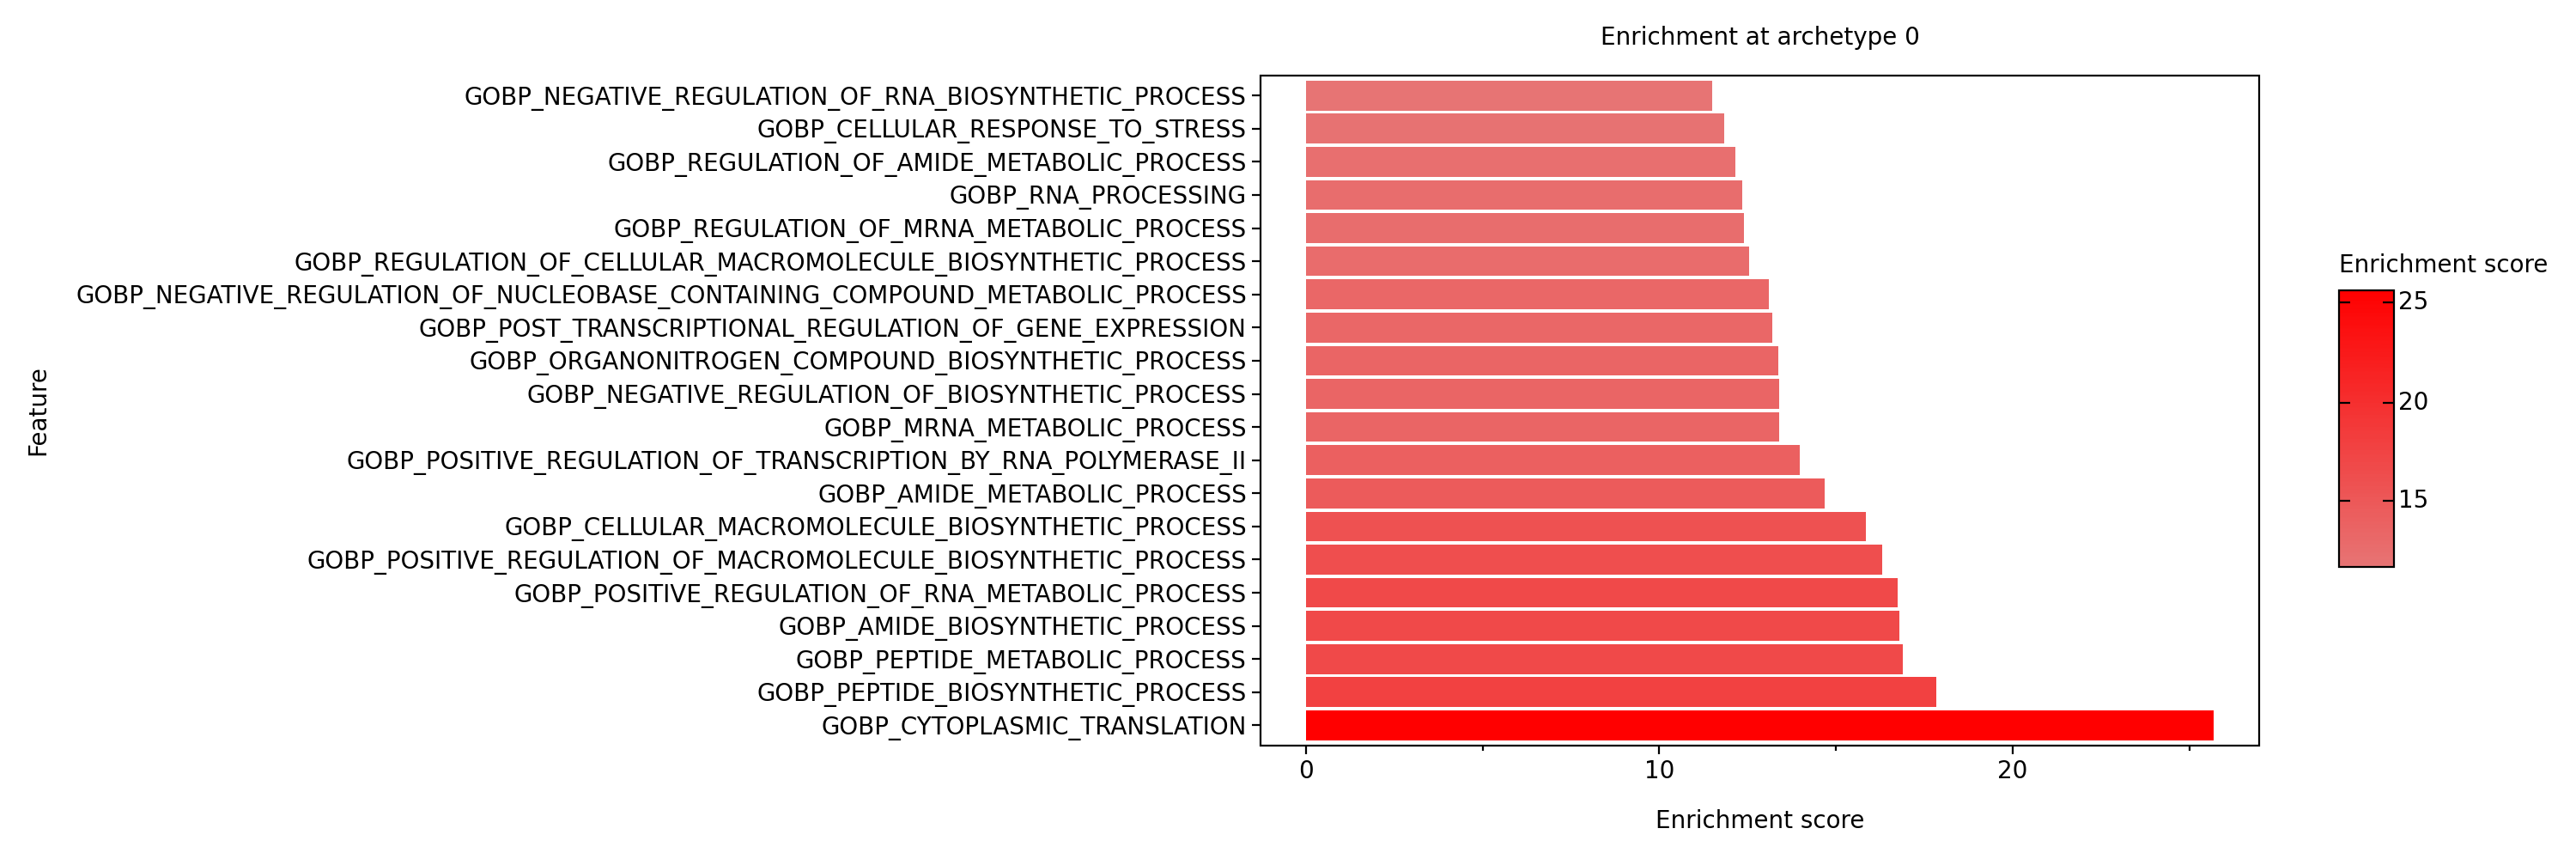

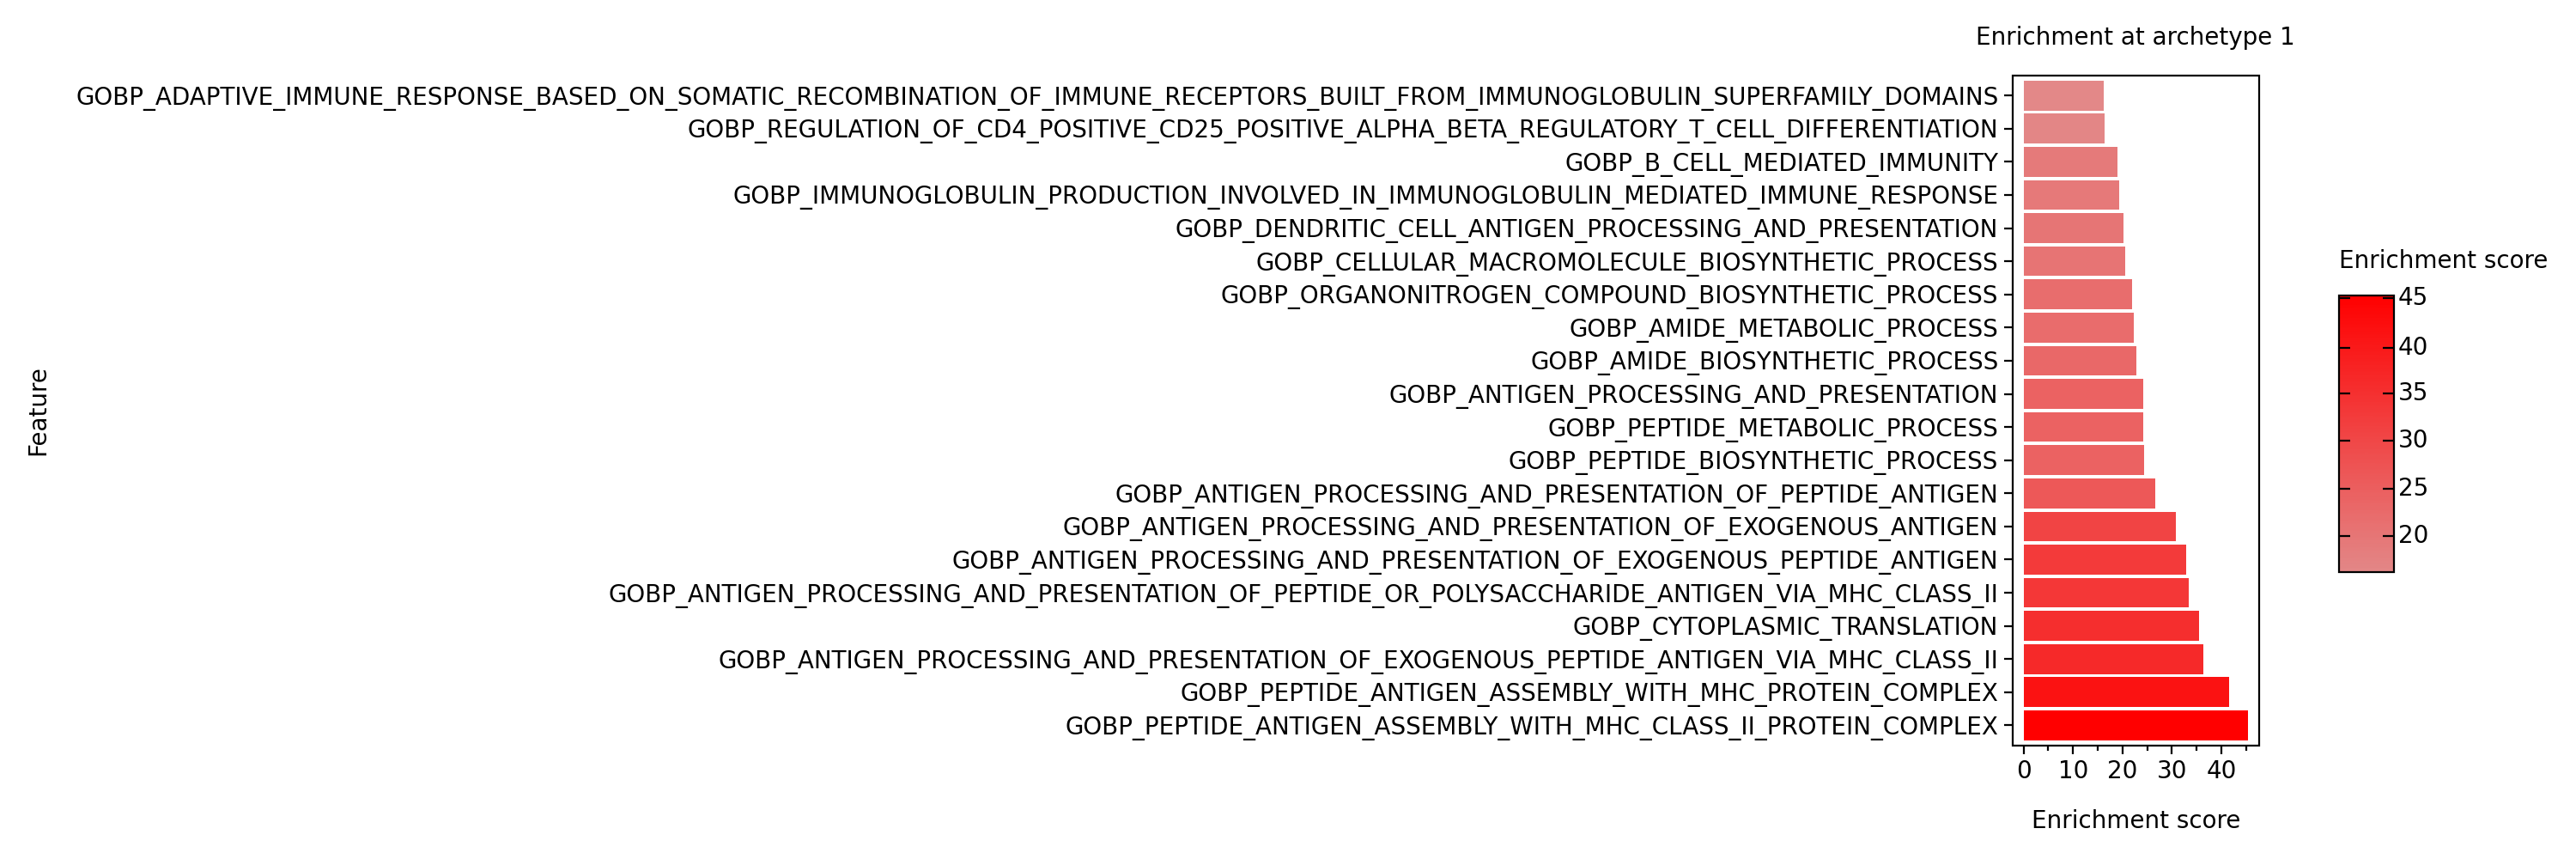

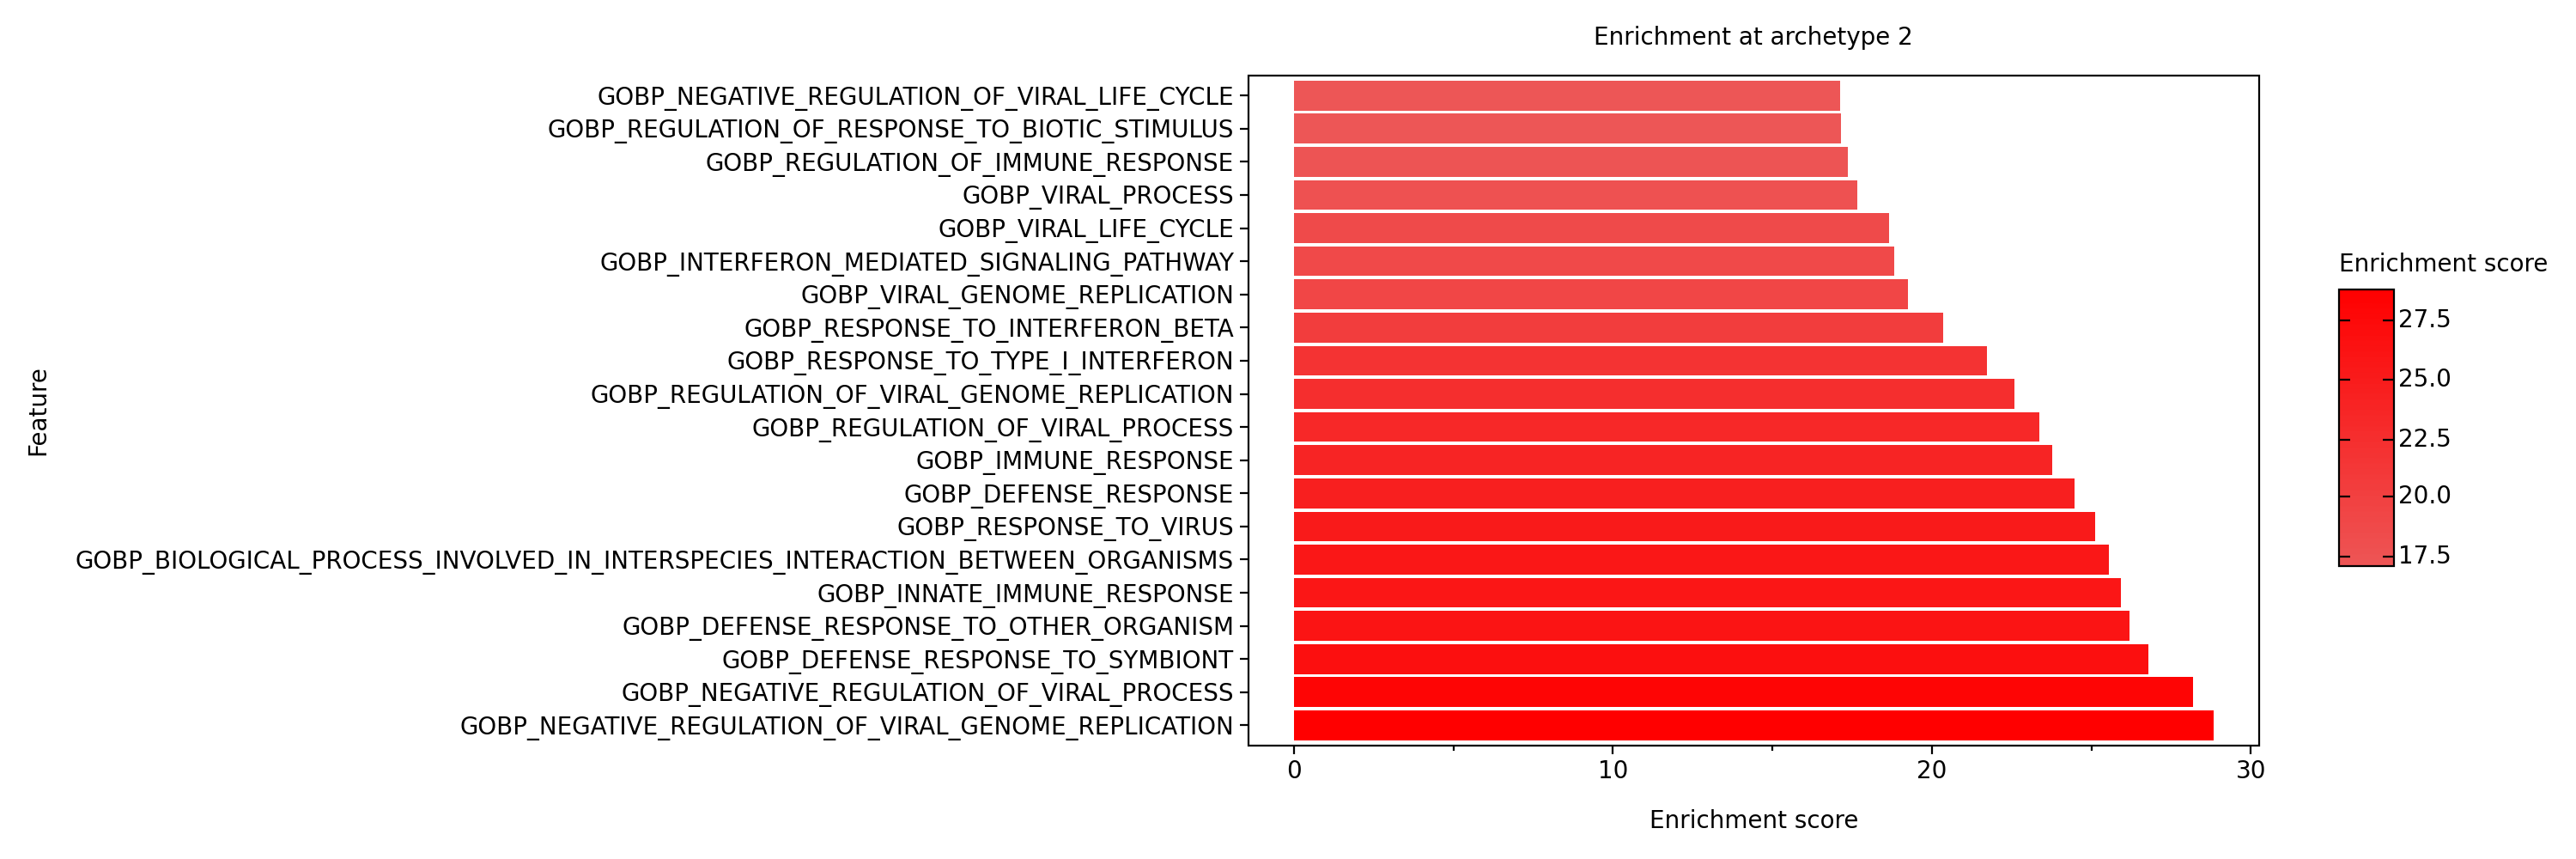

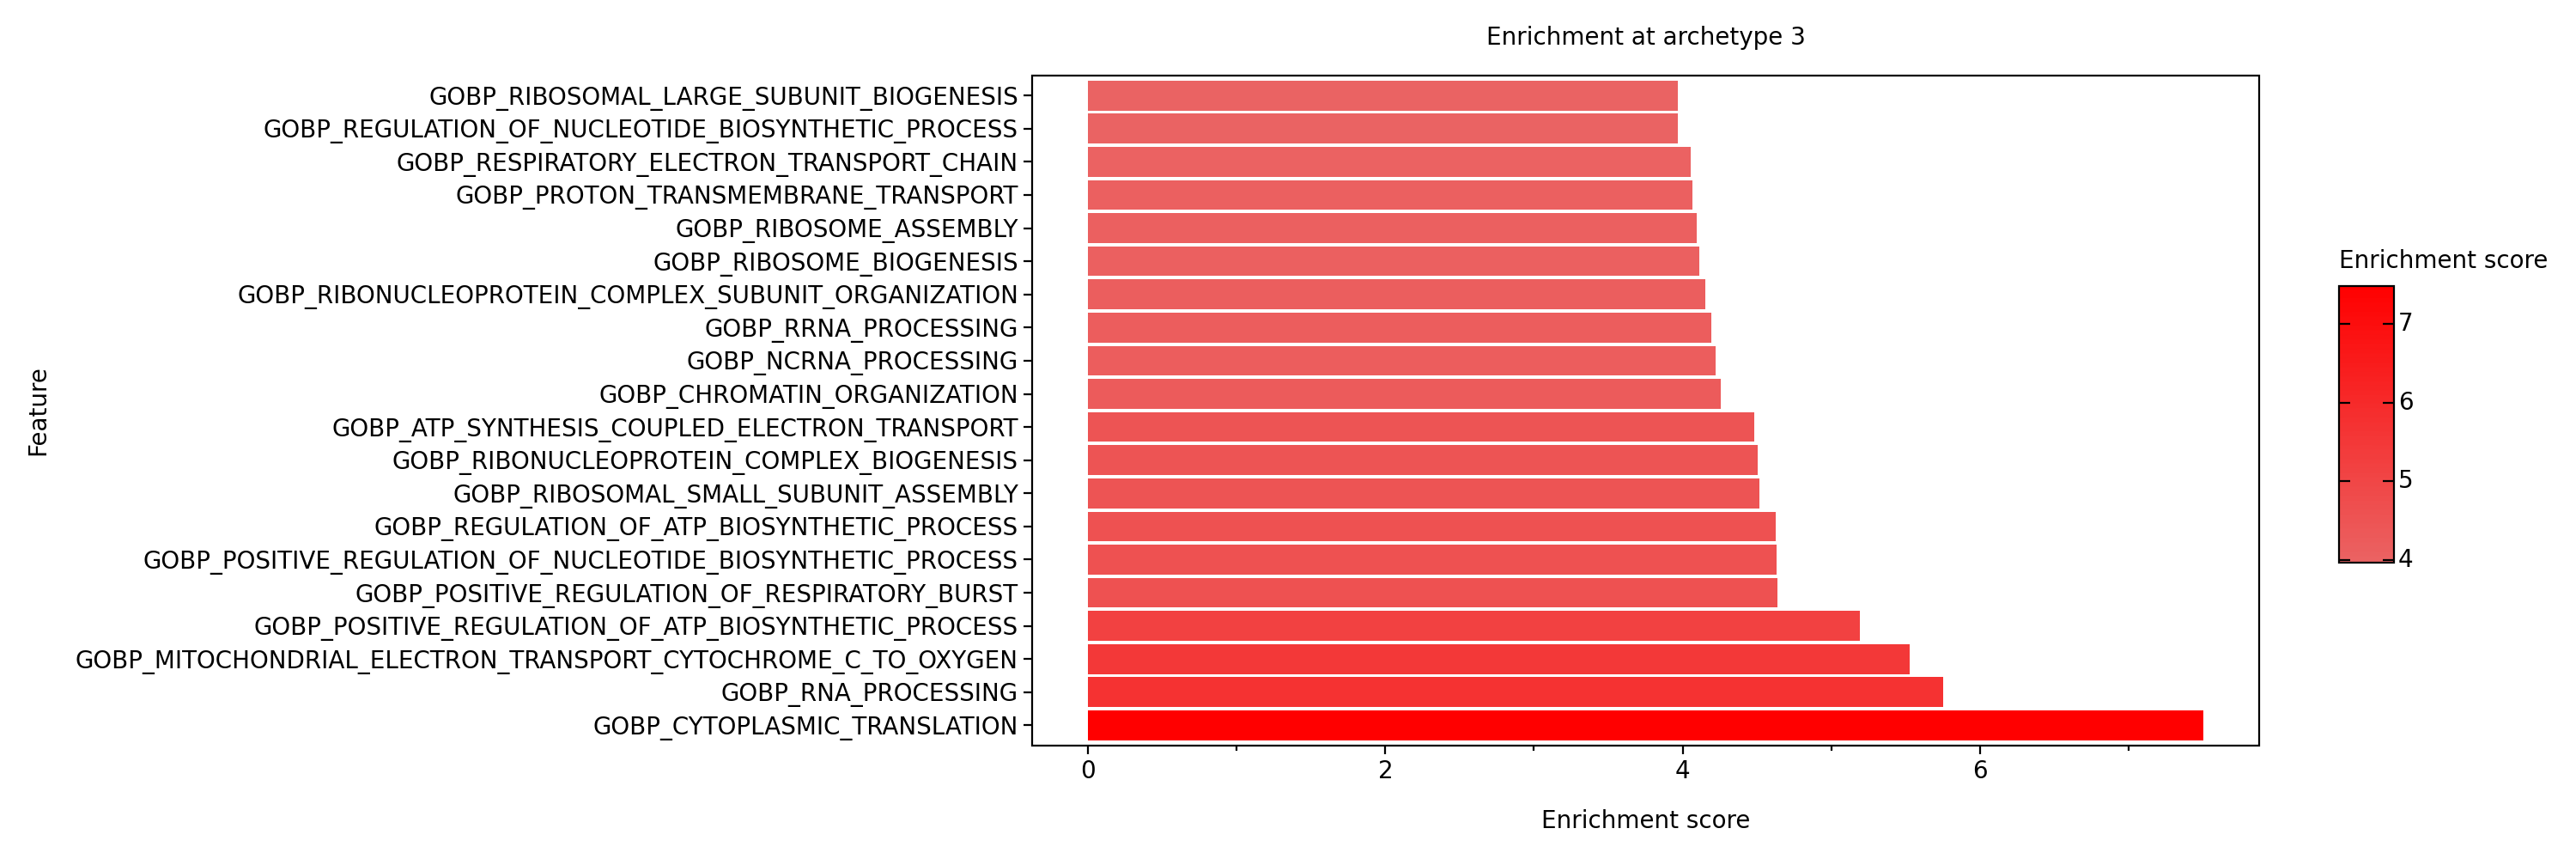

In [46]:
pt.barplot_functional_enrichment(top_processes_msigdb)

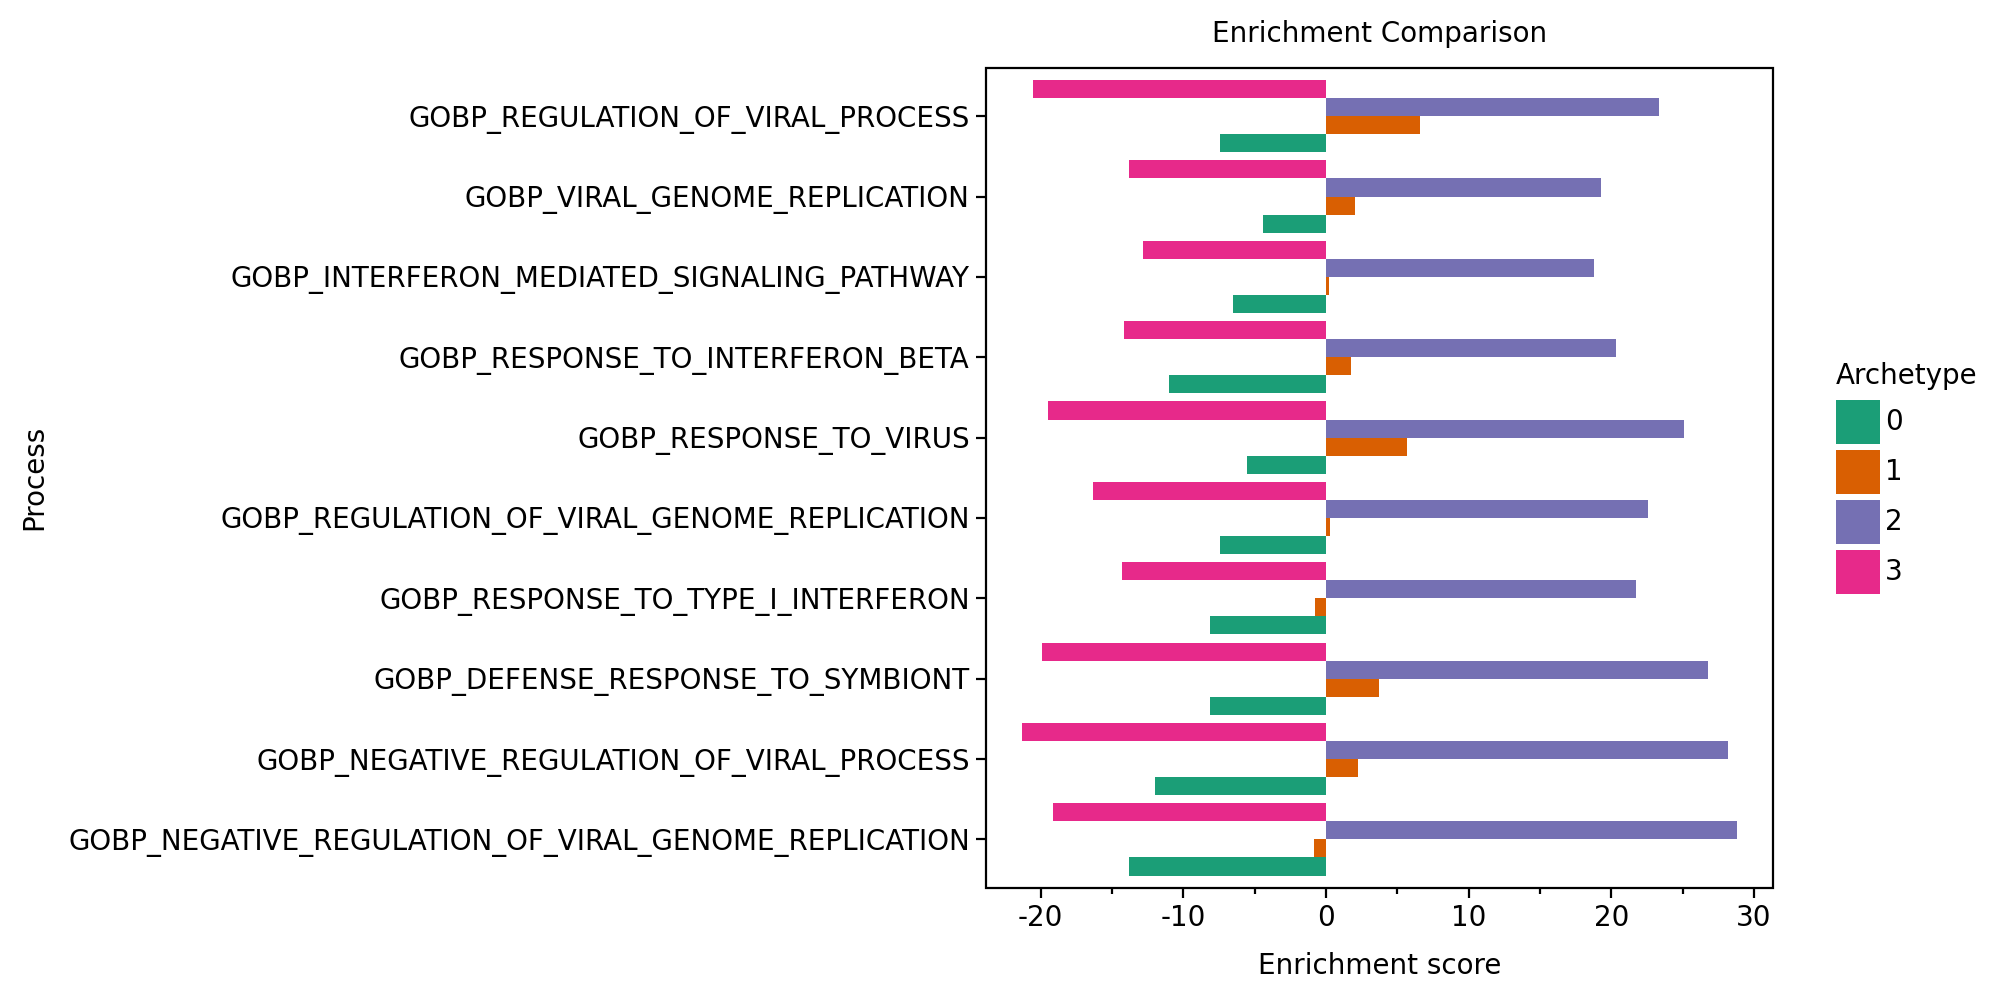

In [47]:
pt.barplot_enrichment_comparison(specific_processes_msigdb[2])

## Functional Enrichment Cytosig

We will repeat the same process now for other resources:

First access the Cytosig data:

In [48]:
cytosig_url = "https://raw.githubusercontent.com/data2intelligence/CytoSig/master/CytoSig/signature.centroid"
cytosig = pd.read_csv(cytosig_url, sep="\t")
cytosig = cytosig.reset_index().rename(columns={"index": "gene"})
cytosig = cytosig.melt(id_vars=["gene"], var_name="cluster", value_name="expression")
cytosig = cytosig.rename({"cluster": "source", "expression": "weight", "gene": "target"}, axis=1)
cytosig["target-source"] = [t + "-" + s for t, s in zip(cytosig["target"], cytosig["source"])]

Now we run enrichment again with decoupler:

In [49]:
acts_ulm_est_cyt, acts_ulm_est_p_cyt = dc.run_ulm(mat = archetype_expression,
                                                  net = cytosig,
                                                  weight = "weight",
                                                  source="source",
                                                  target="target")

acts_ulm_est_cyt

Activin A      BDNF      BMP2      BMP4      BMP6      CD40L     CXCL12  \
0   0.003870  3.117057  3.321686 -3.257797 -2.349026   9.537024   3.583333   
1  -2.481938 -1.035835 -0.418278 -1.252795 -6.450640  -4.786545  -0.283615   
2   2.752997  5.218882  3.932085  6.140778 -6.503607  -1.821405   3.778725   
3  -4.933489 -4.035338 -3.684308 -8.484237  5.847368 -10.561925 -10.773185   

         EGF      FGF2      GCSF  ...       MCSF        NO        OSM  \
0  13.810579 -0.842500  1.640108  ...  -7.507592  5.297960  -5.015934   
1   0.256287  2.266199 -6.509143  ...   0.391596 -9.279981   9.983353   
2   2.356315  3.373260  2.836862  ...   2.025224 -0.714388  15.413237   
3  -4.134778 -8.115843 -7.917665  ... -11.447375 -9.335971 -15.443235   

      TGFB1      TGFB3       TNFA      TRAIL      TWEAK      VEGFA     WNT3A  
0  3.861378  10.854022   6.269478  13.898932   5.956192  10.083340 -0.347683  
1 -7.997129  -9.220815   0.860453  -1.129295   5.653547  -1.970081 -5.725967  
2 -5.859613  -6.779016   9.190125   0.814763   5.139276  -1.965110 -4.351713  
3 -1.295031  -3.781985 -18.923248  -8.803668 -10.969221  -3.749590  3.473851  

[4 rows x 43 columns]

Extract top processes:

In [50]:
top_processes_cyt = pt.extract_enriched_processes(est=acts_ulm_est_cyt, 
                                                  pval=acts_ulm_est_p_cyt, 
                                                  order="desc", 
                                                  n=20, 
                                                  p_threshold=0.05)

In [51]:
specific_processes_cyt = pt.extract_specific_processes(est=acts_ulm_est_cyt, 
                                                       pval=acts_ulm_est_p_cyt, 
                                                       n=10, 
                                                       p_threshold=0.05)

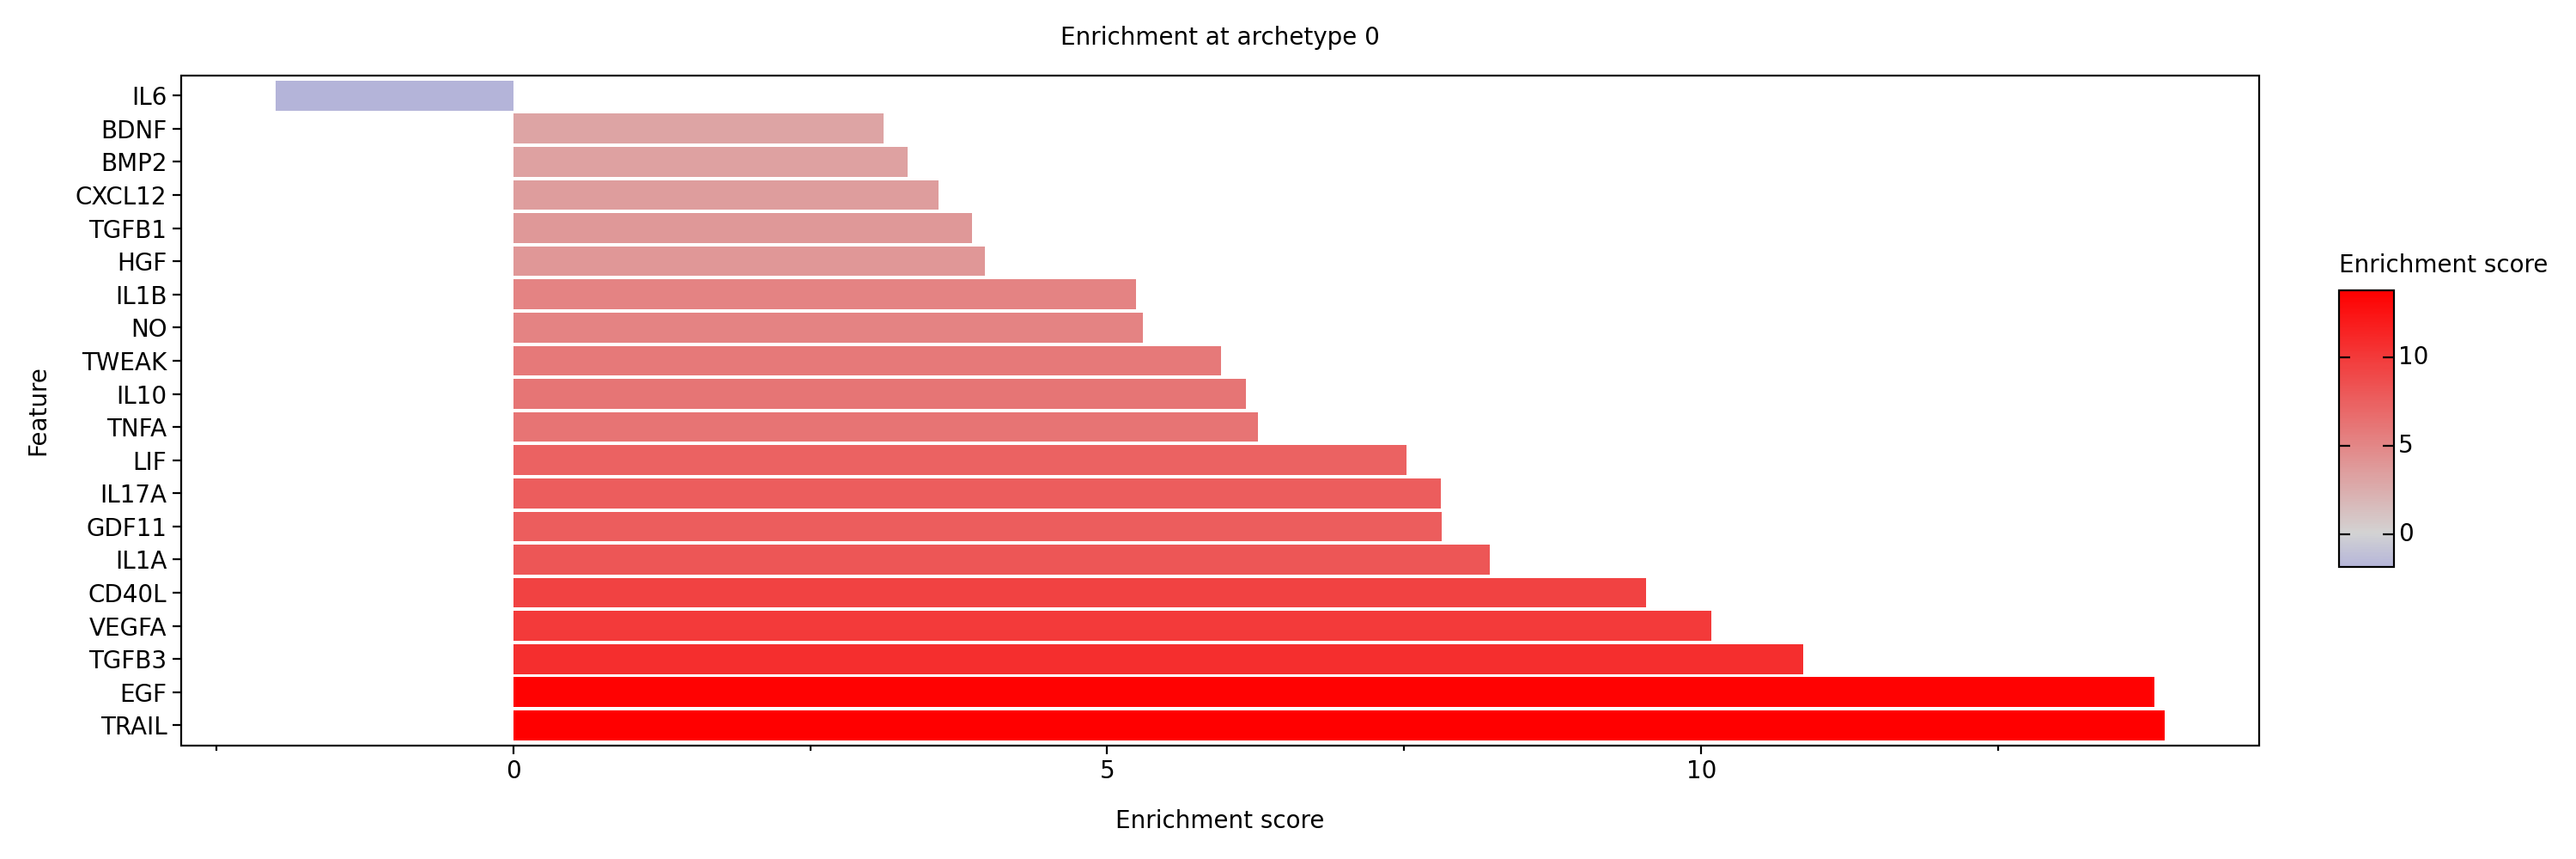

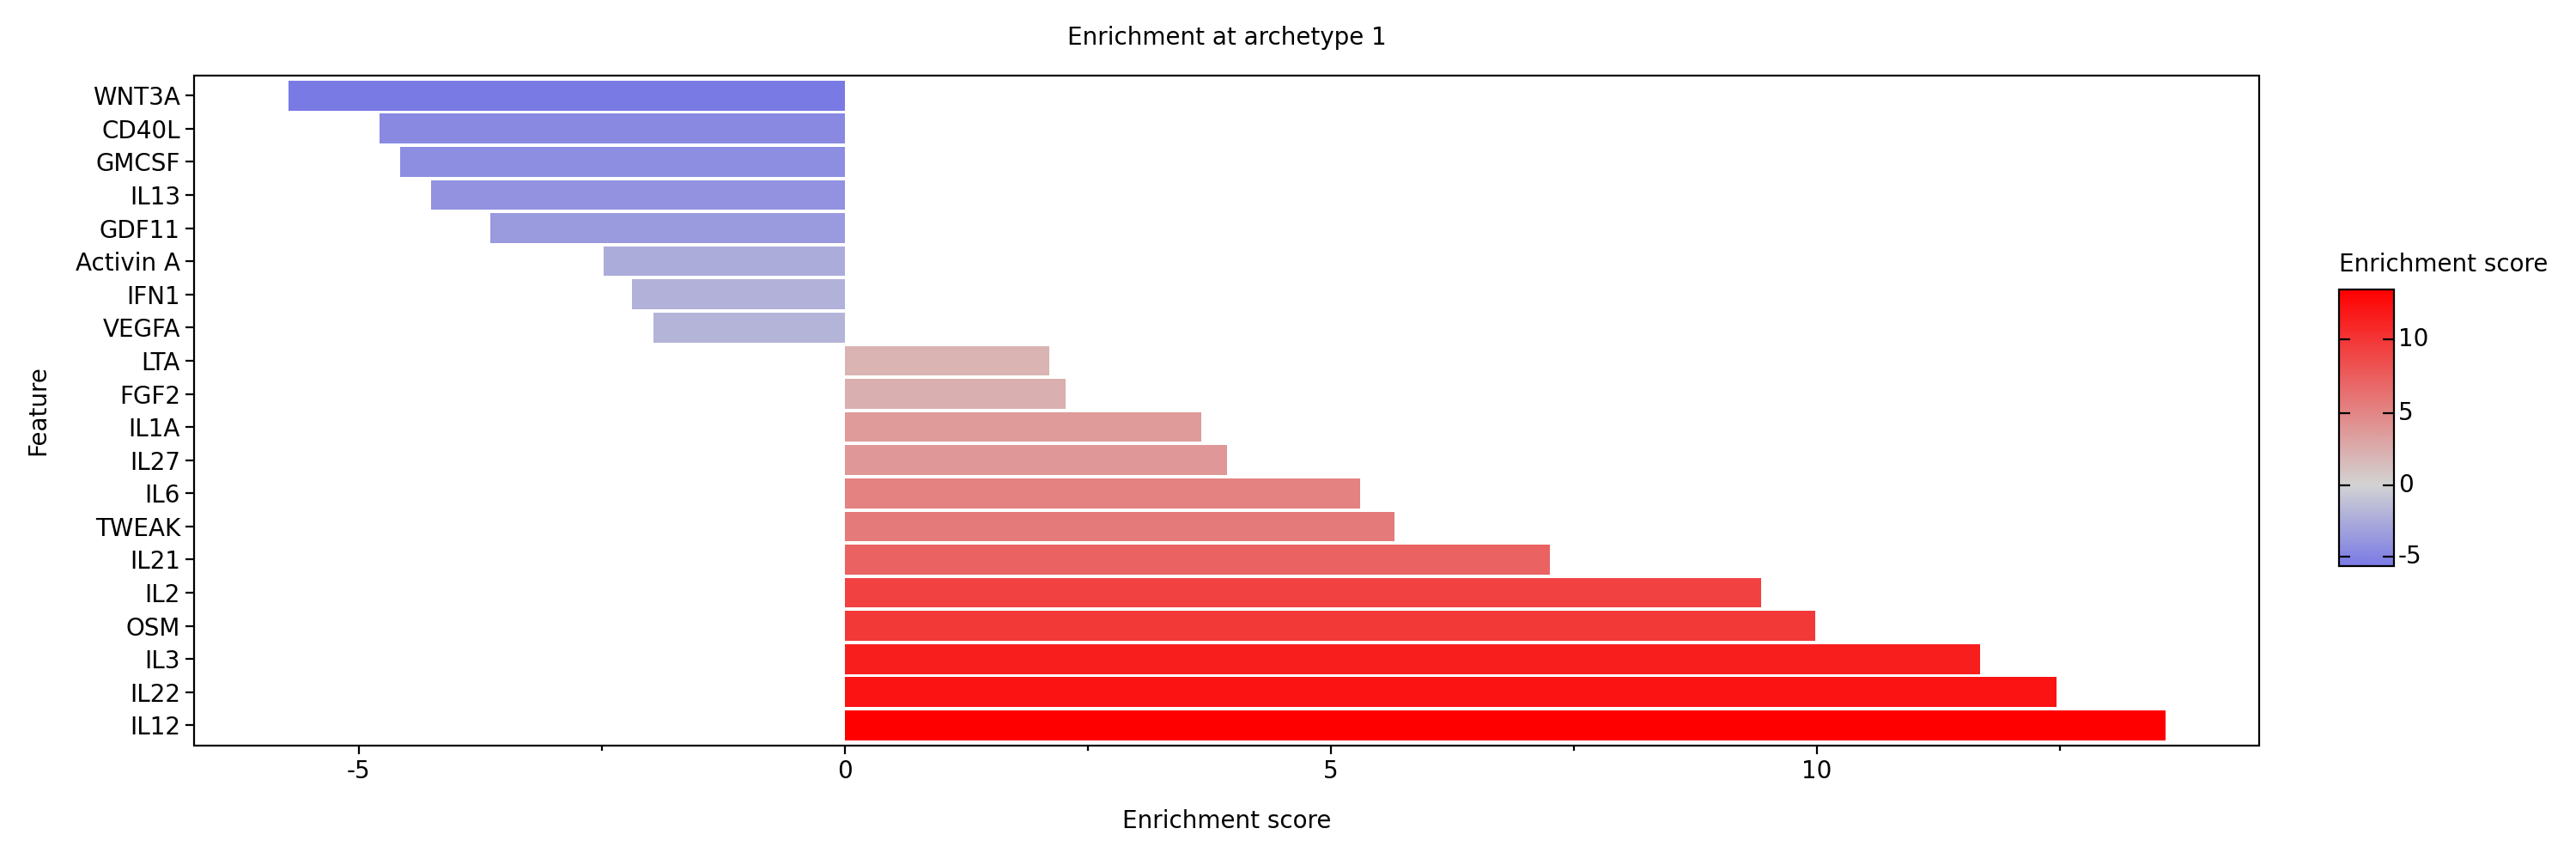

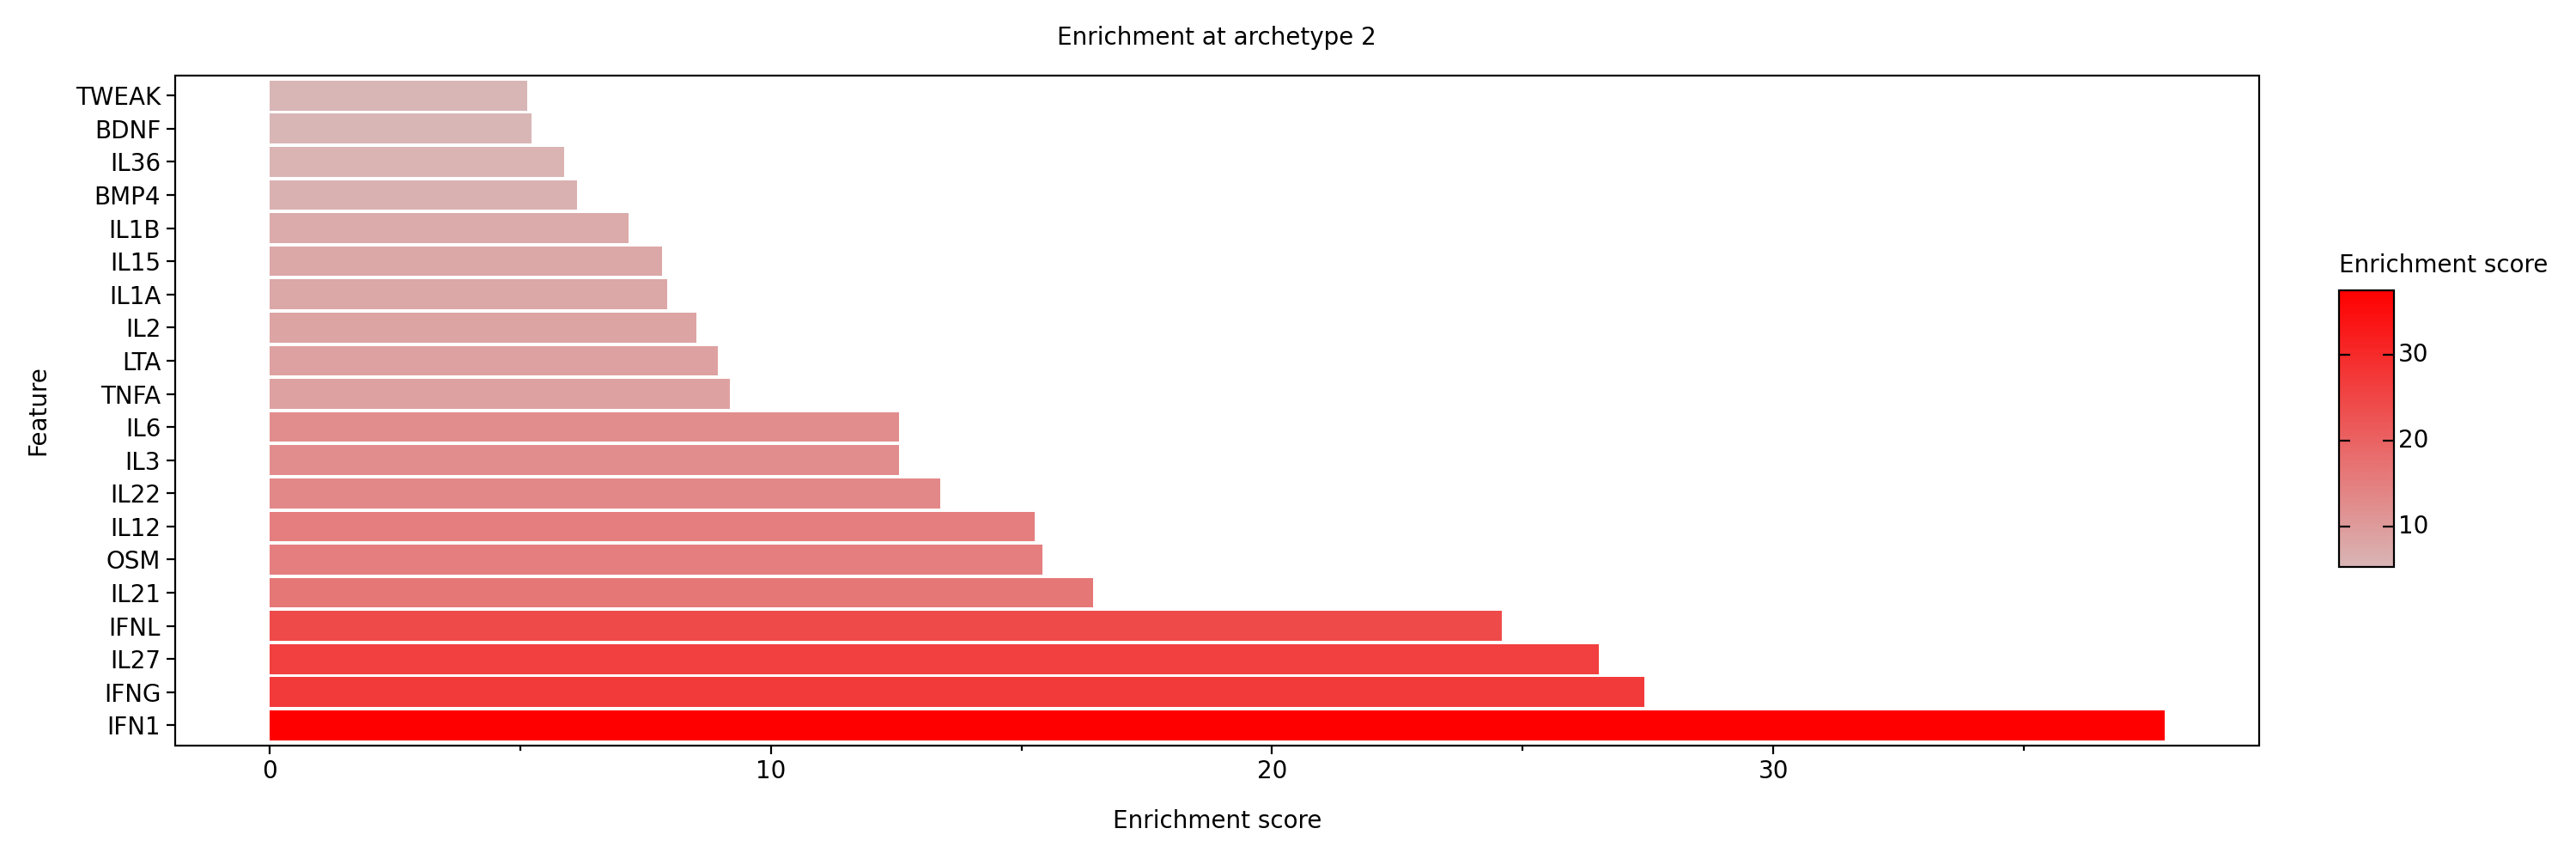

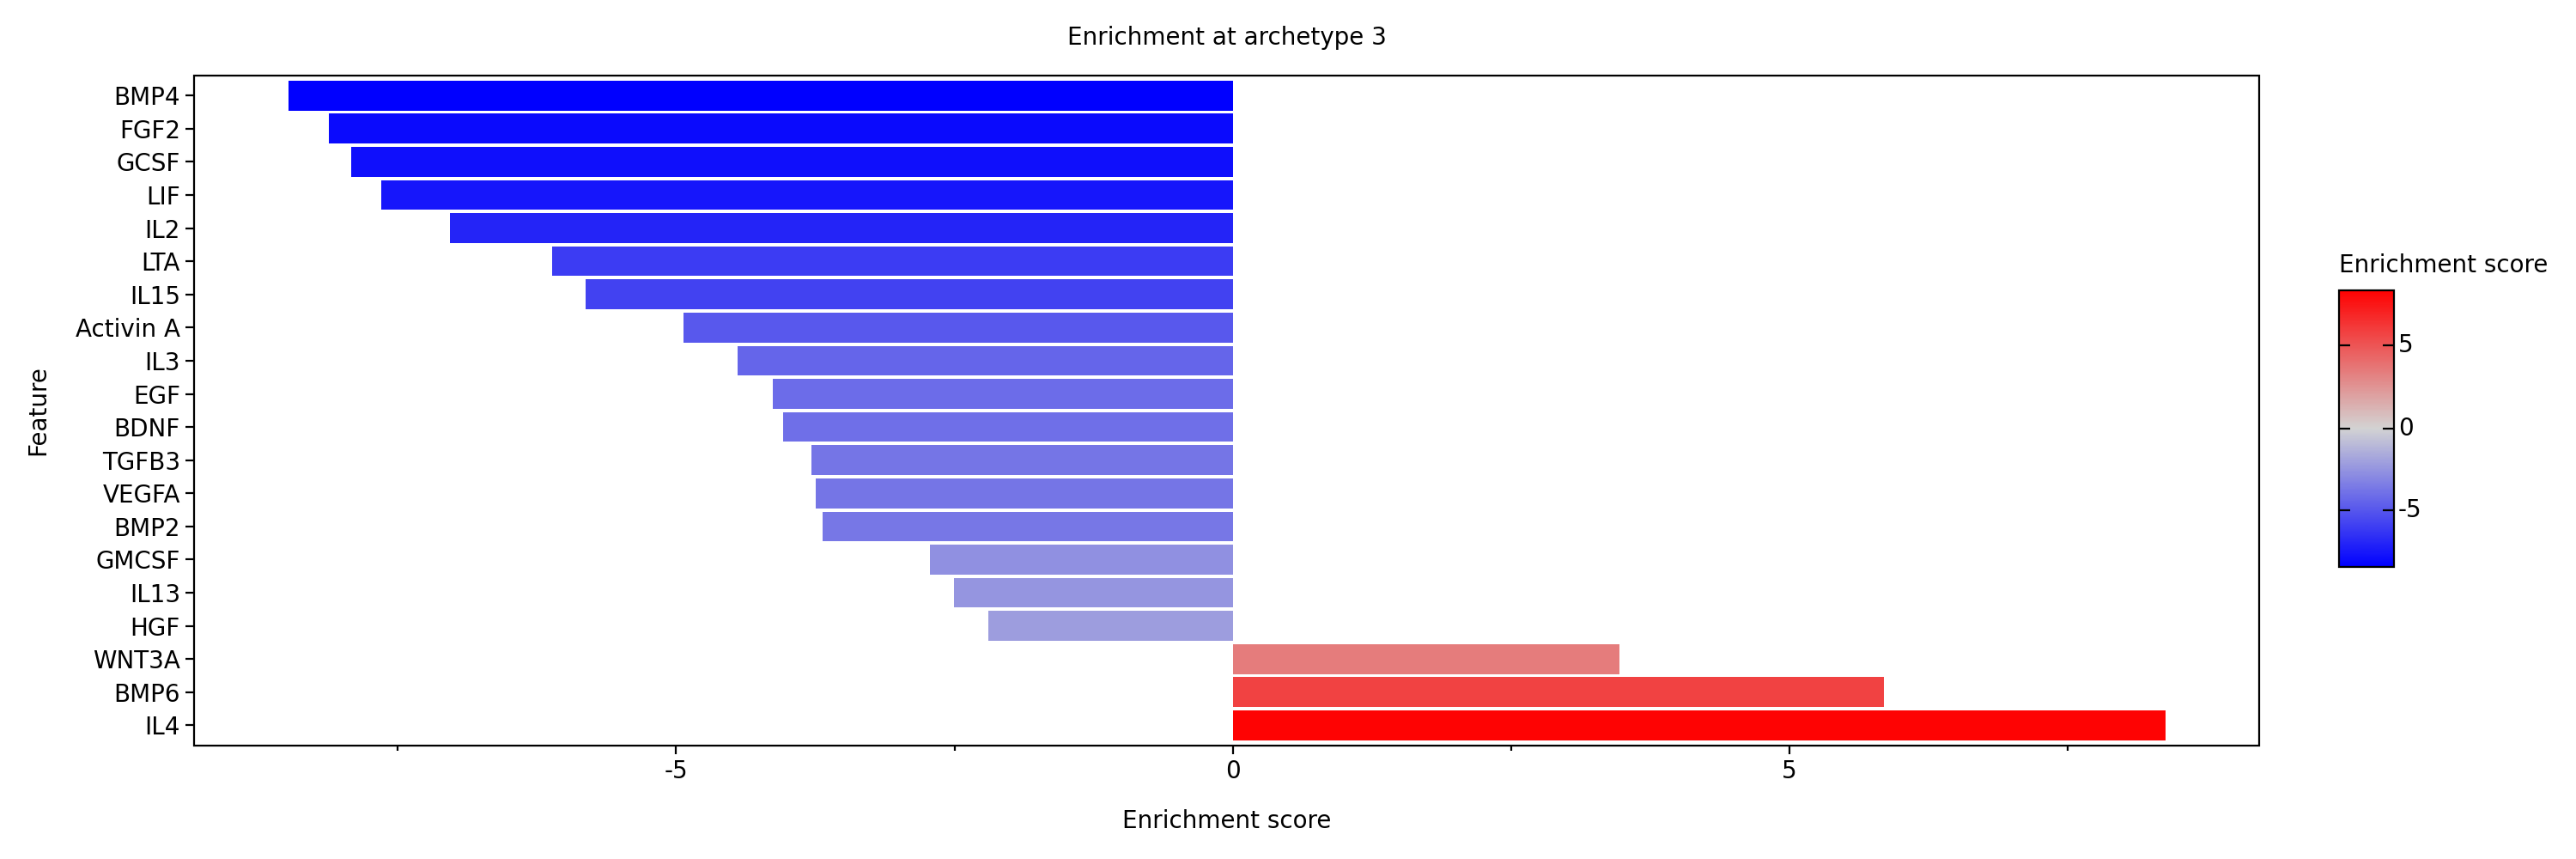

In [52]:
pt.barplot_functional_enrichment(top_processes_cyt)

Archetype 2 associated with flare:

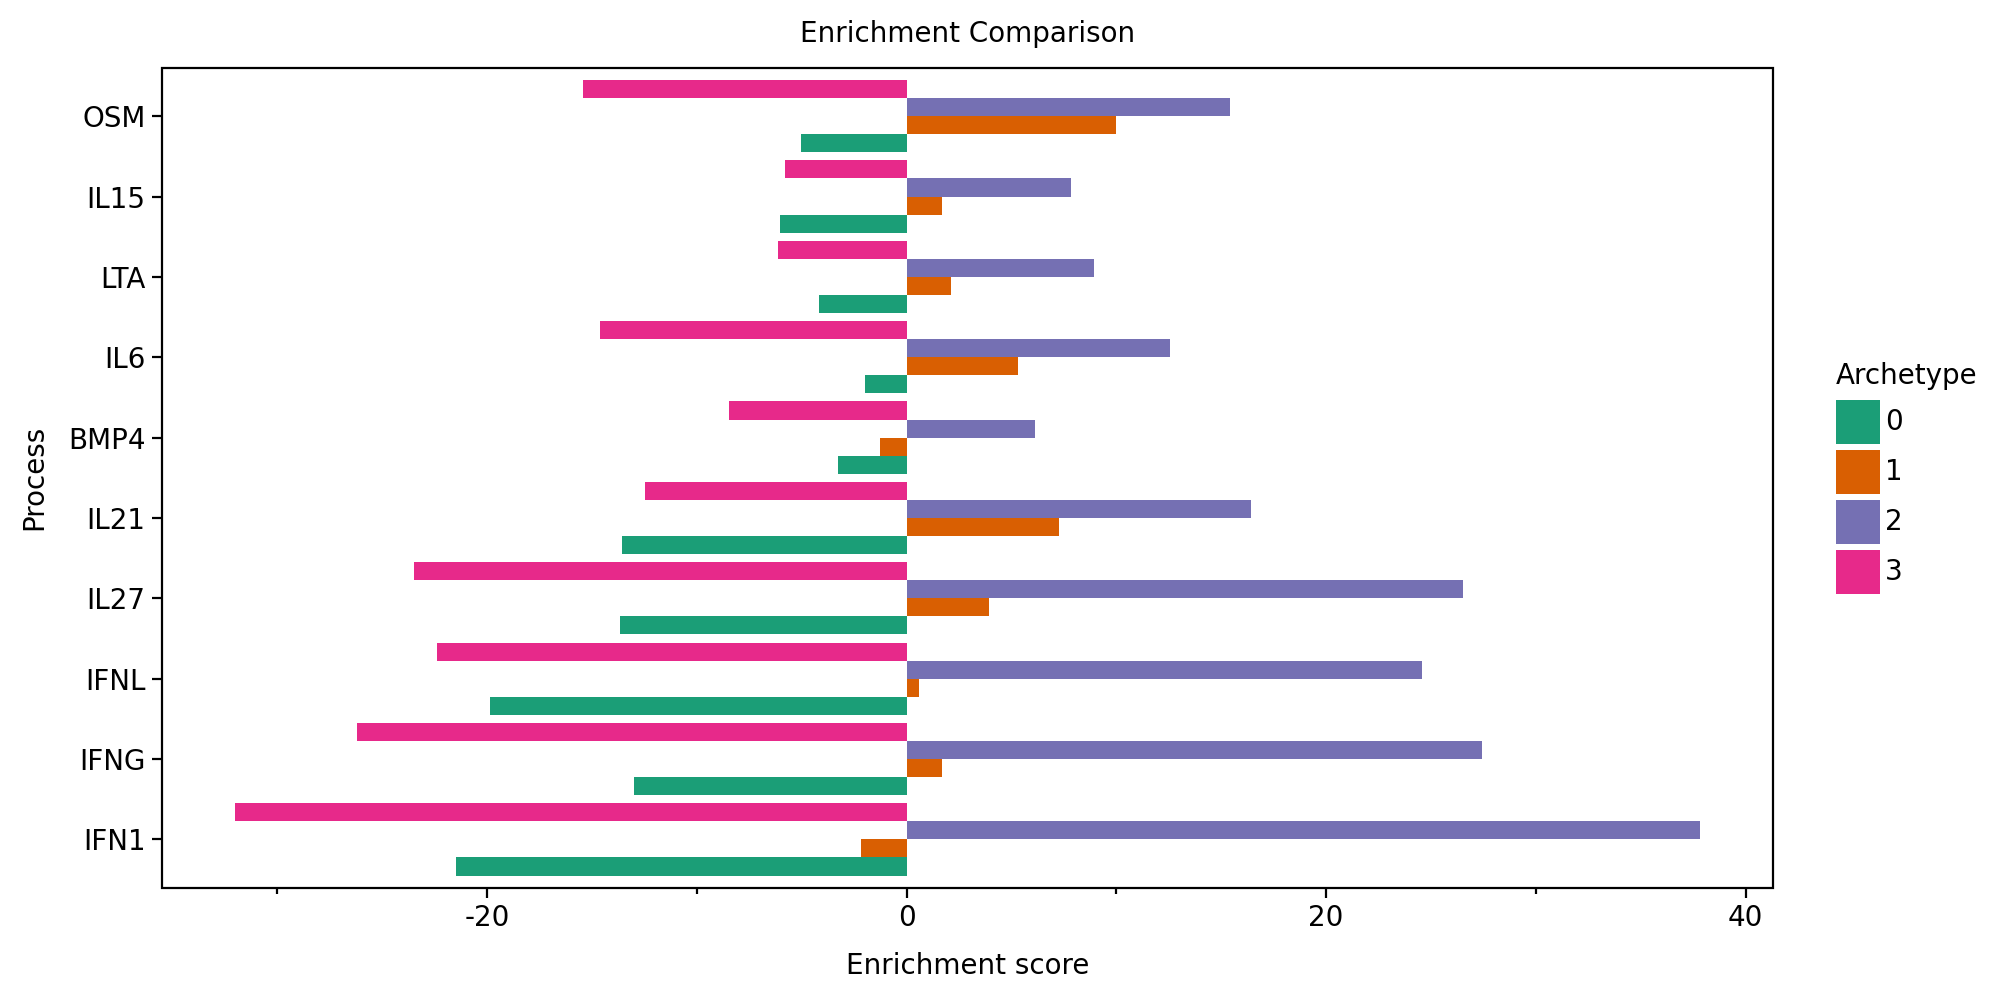

In [53]:
pt.barplot_enrichment_comparison(specific_processes_cyt[2])

## Functional Enrichment CollecTRI

Get resource:

In [54]:
collectri = dc.get_collectri(organism="human", split_complexes=False)
collectri

source  target  weight
0       ABL1     BAX       1
1       ABL1    BCL2      -1
2       ABL1    BCL6      -1
3       ABL1   CCND2       1
4       ABL1  CDKN1A       1
...      ...     ...     ...
40625   ZXDC  CDKN1C       1
40626   ZXDC  CDKN2A       1
40627   ZXDC   CIITA       1
40628   ZXDC   HLA-E       1
40629   ZXDC     IL5       1

[40630 rows x 3 columns]

Estimate enrichment:

In [55]:
acts_ulm_est_collectri, acts_ulm_est_p_collectri = dc.run_ulm(mat = archetype_expression,
                                                              net = collectri,
                                                              weight = "weight",
                                                              source="source",
                                                              target="target")

acts_ulm_est_collectri

ABL1       AHR       AIP      AIRE       AP1     APEX1        AR  \
0  0.570772  1.976689 -0.377884  6.030508  3.632924  1.119047  5.214641   
1  0.941894  2.695992  0.280672  0.297943  5.280266  0.959526  2.227685   
2  3.379212  3.921321  0.068174  0.999427  7.546421  1.497551  2.190723   
3 -4.272073 -6.488444  0.159788 -5.417977 -9.299310 -2.199395 -2.788373   

     ARID1A    ARID1B    ARID3A  ...    ZNF382    ZNF384    ZNF395    ZNF410  \
0 -0.267350  0.014136 -1.235851  ... -3.490338  1.689676 -2.083793  1.133401   
1 -0.041812 -0.919600 -0.418371  ... -1.434001 -1.023241 -0.267969  0.321146   
2  1.834100 -0.425355  2.428134  ... -0.181184 -0.388244  4.879250  0.022025   
3 -2.114361 -0.067635 -2.249191  ...  2.269091 -0.063043 -2.628220  0.357297   

     ZNF436    ZNF699     ZNF76   ZNF804A     ZNF91      ZXDC  
0  0.928318  1.624390  0.815034  1.200985  1.305158  1.449843  
1  0.416825  0.024936  0.029435 -1.010295  0.514643 -2.760154  
2  0.752146 -0.582308 -1.188076  0.237986  2.920271  0.500452  
3 -0.720188  0.377423  2.501054  0.200475 -3.390685  0.669010  

[4 rows x 654 columns]

Extract top scores:

In [56]:
top_processes_collectri = pt.extract_enriched_processes(est=acts_ulm_est_collectri, 
                                                        pval=acts_ulm_est_p_collectri, 
                                                        order="desc", 
                                                        n=20, 
                                                        p_threshold=0.05)

In [57]:
specific_processes_collectri = pt.extract_specific_processes(est=acts_ulm_est_collectri, 
                                                             pval=acts_ulm_est_p_collectri, 
                                                             n=10, 
                                                             p_threshold=0.05)

Plot results:

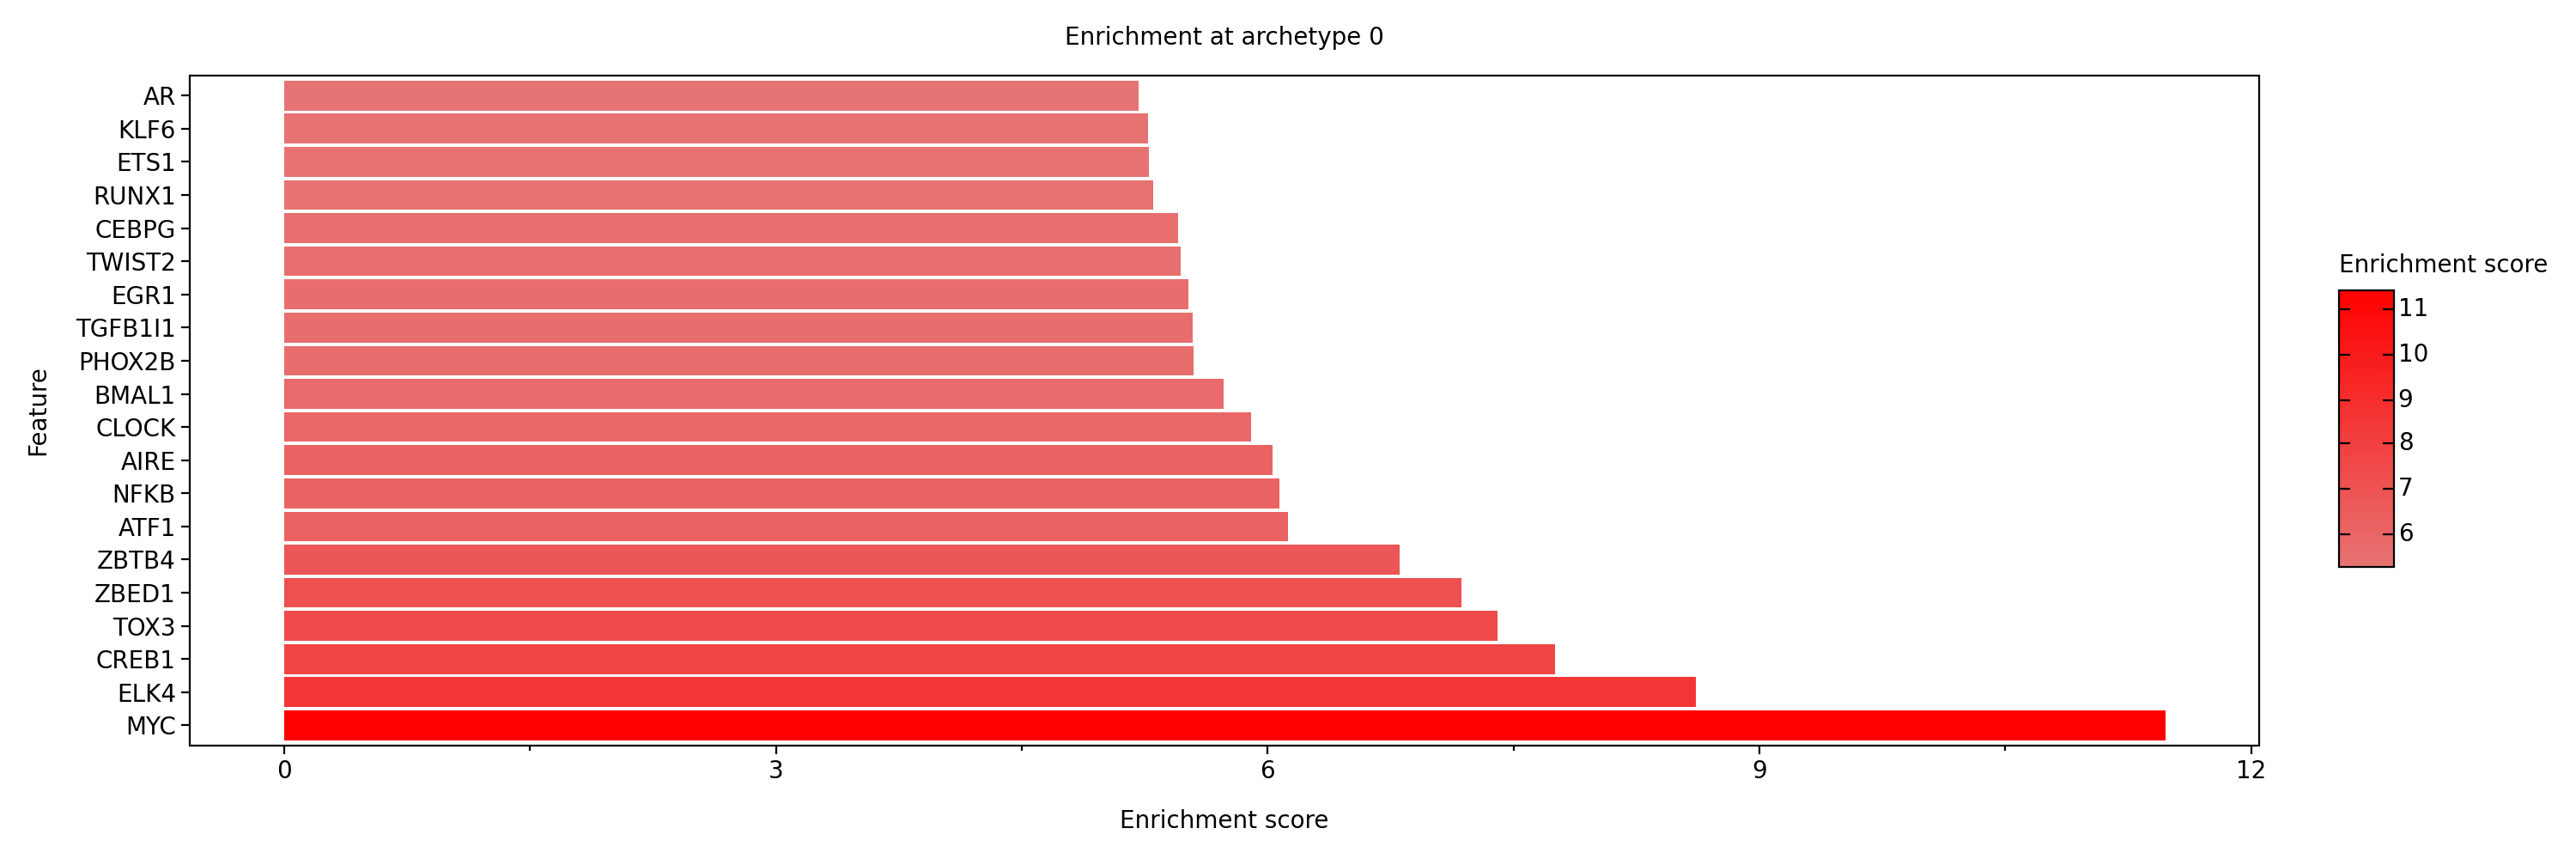

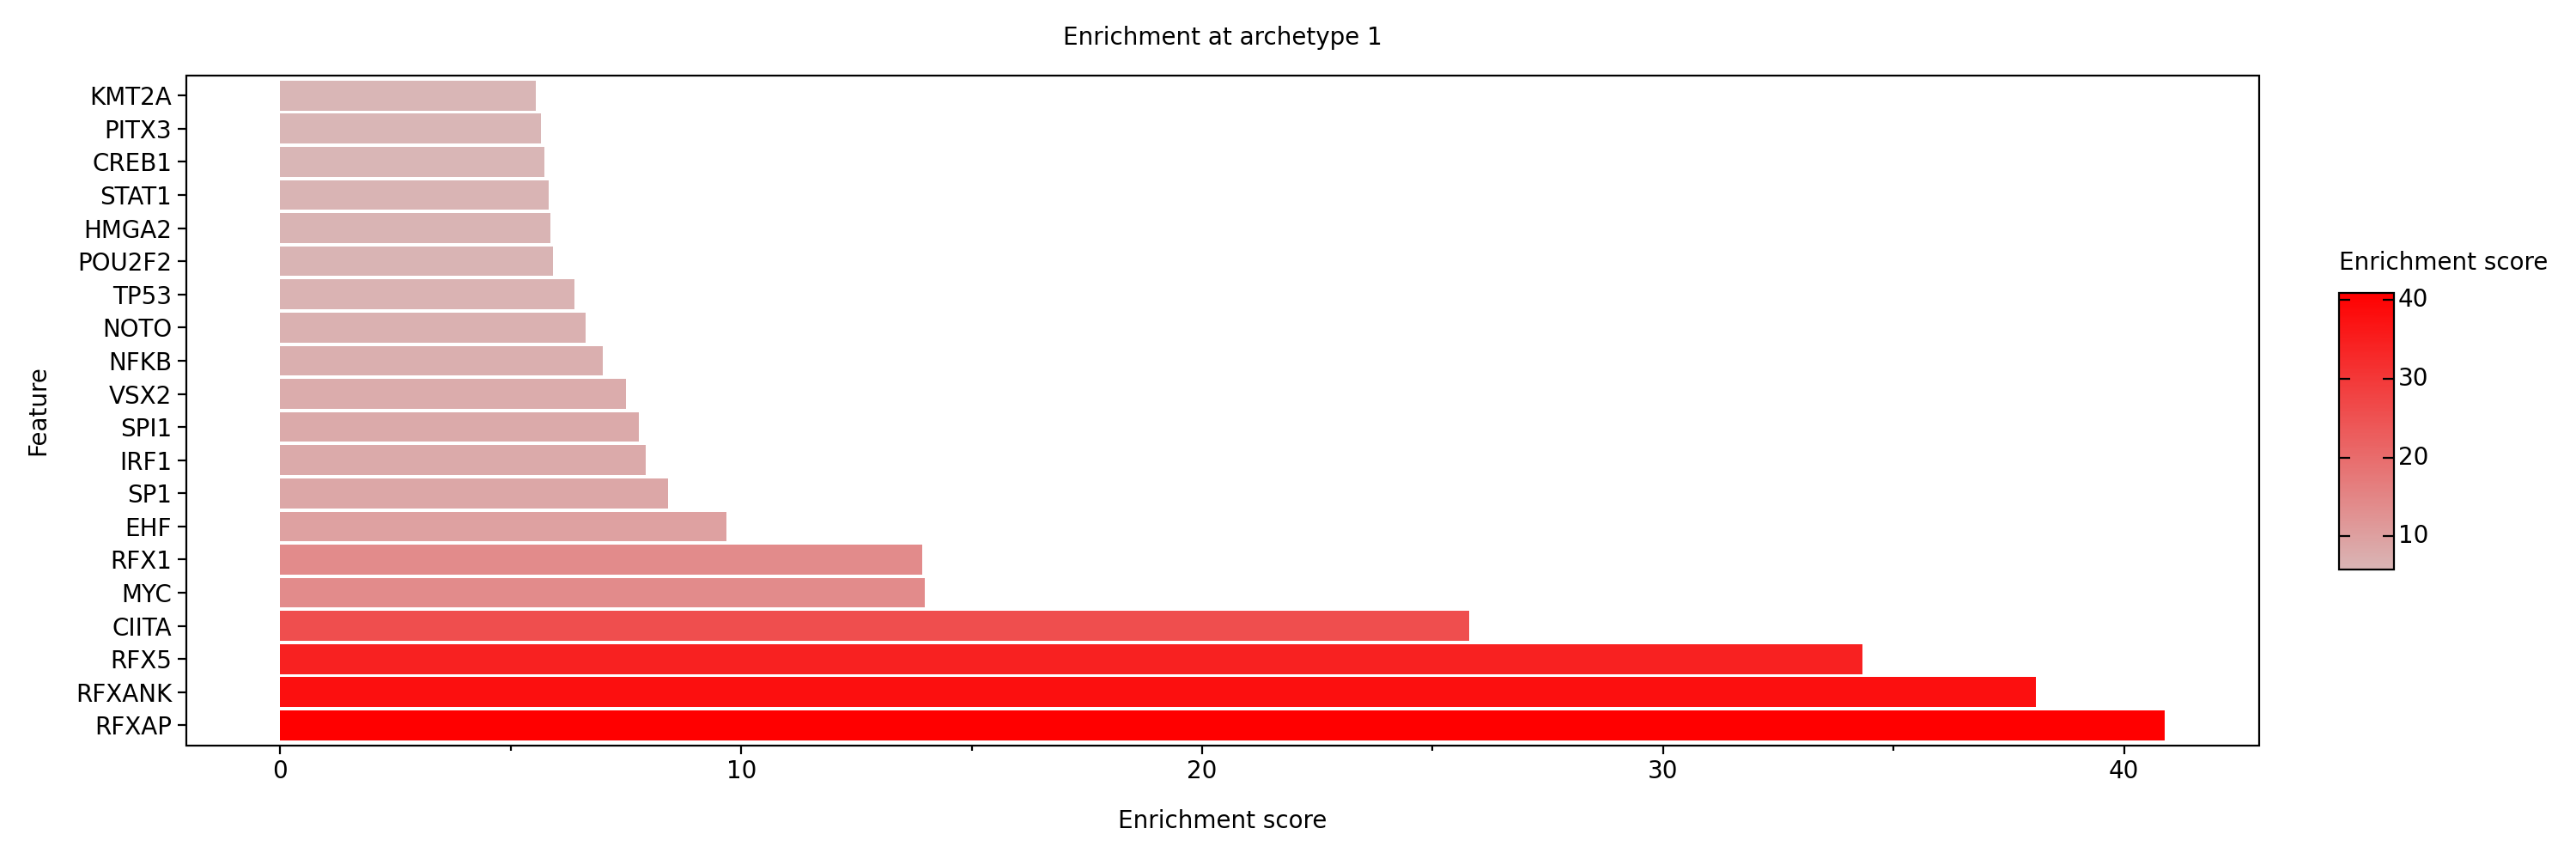

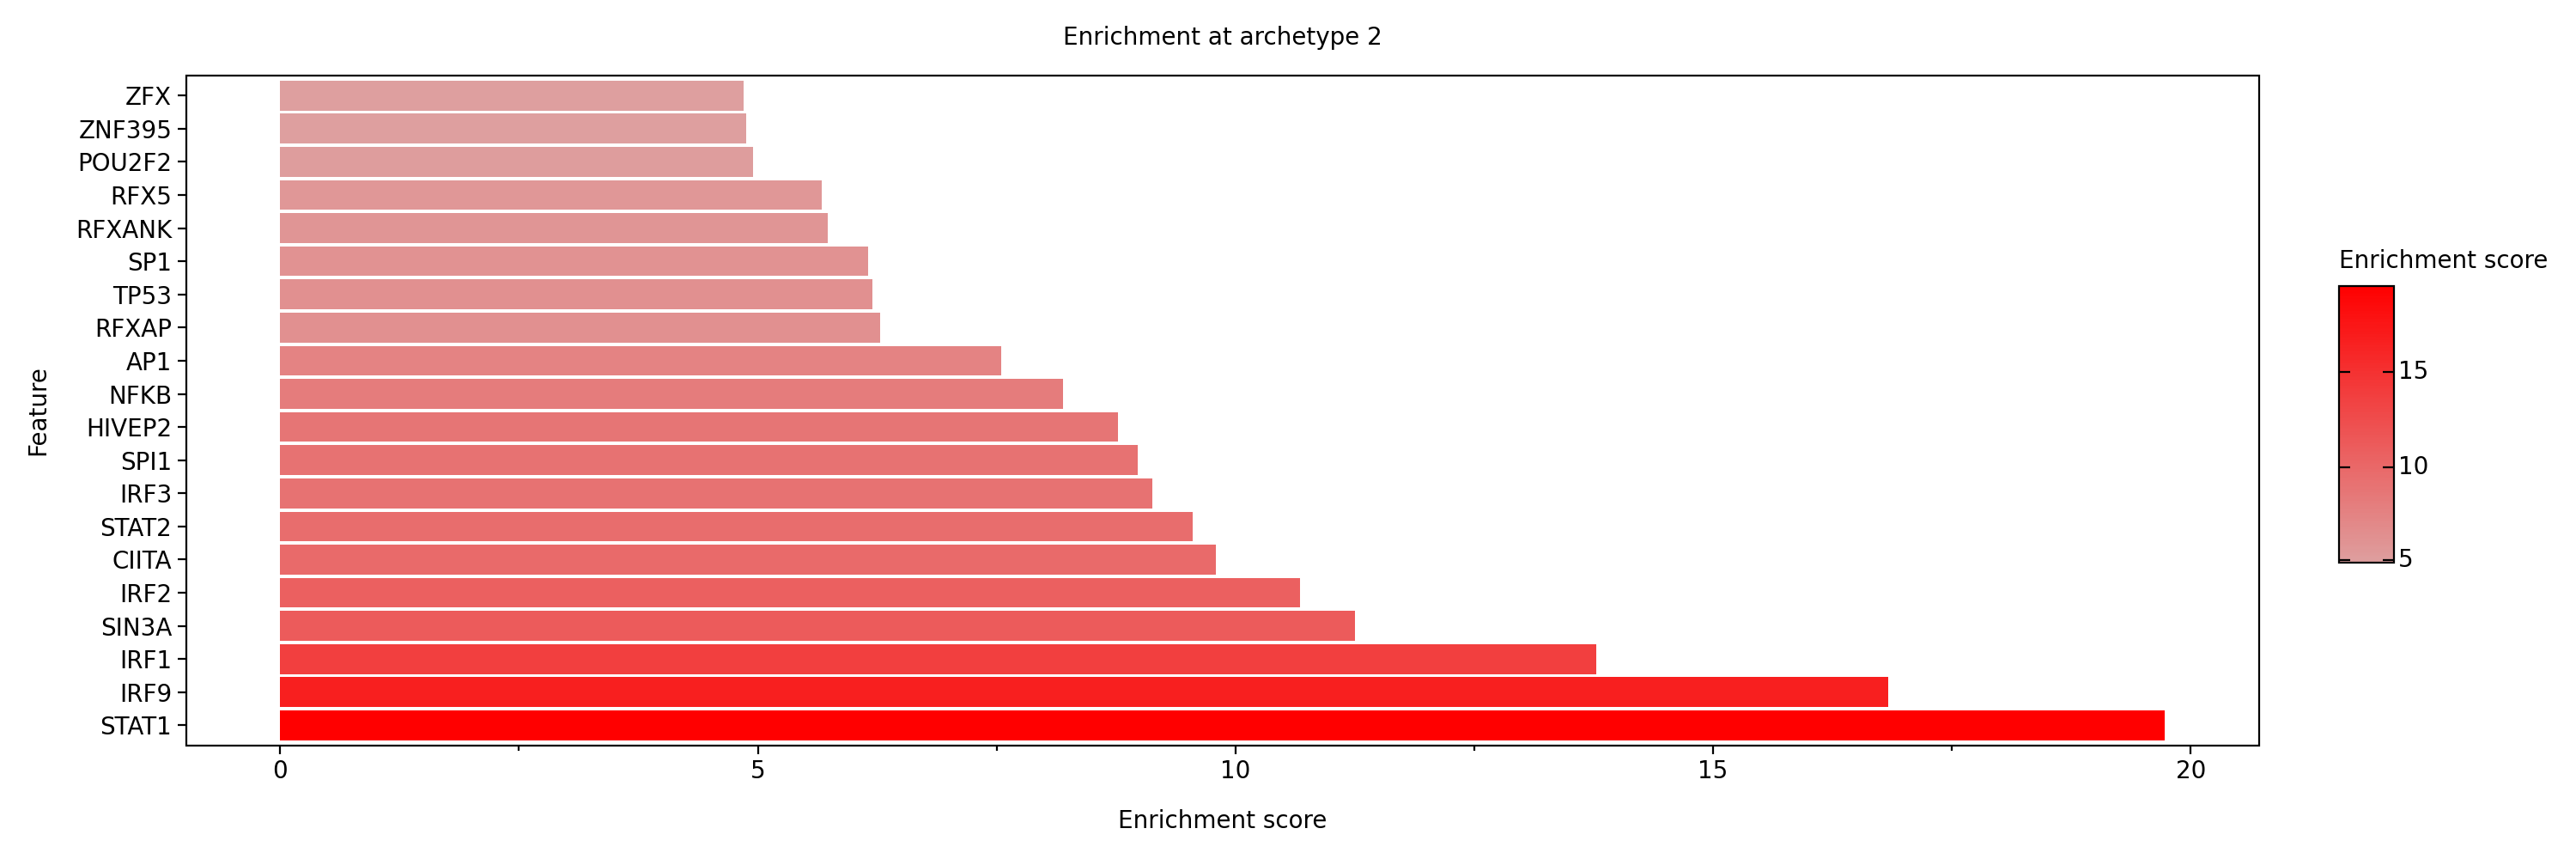

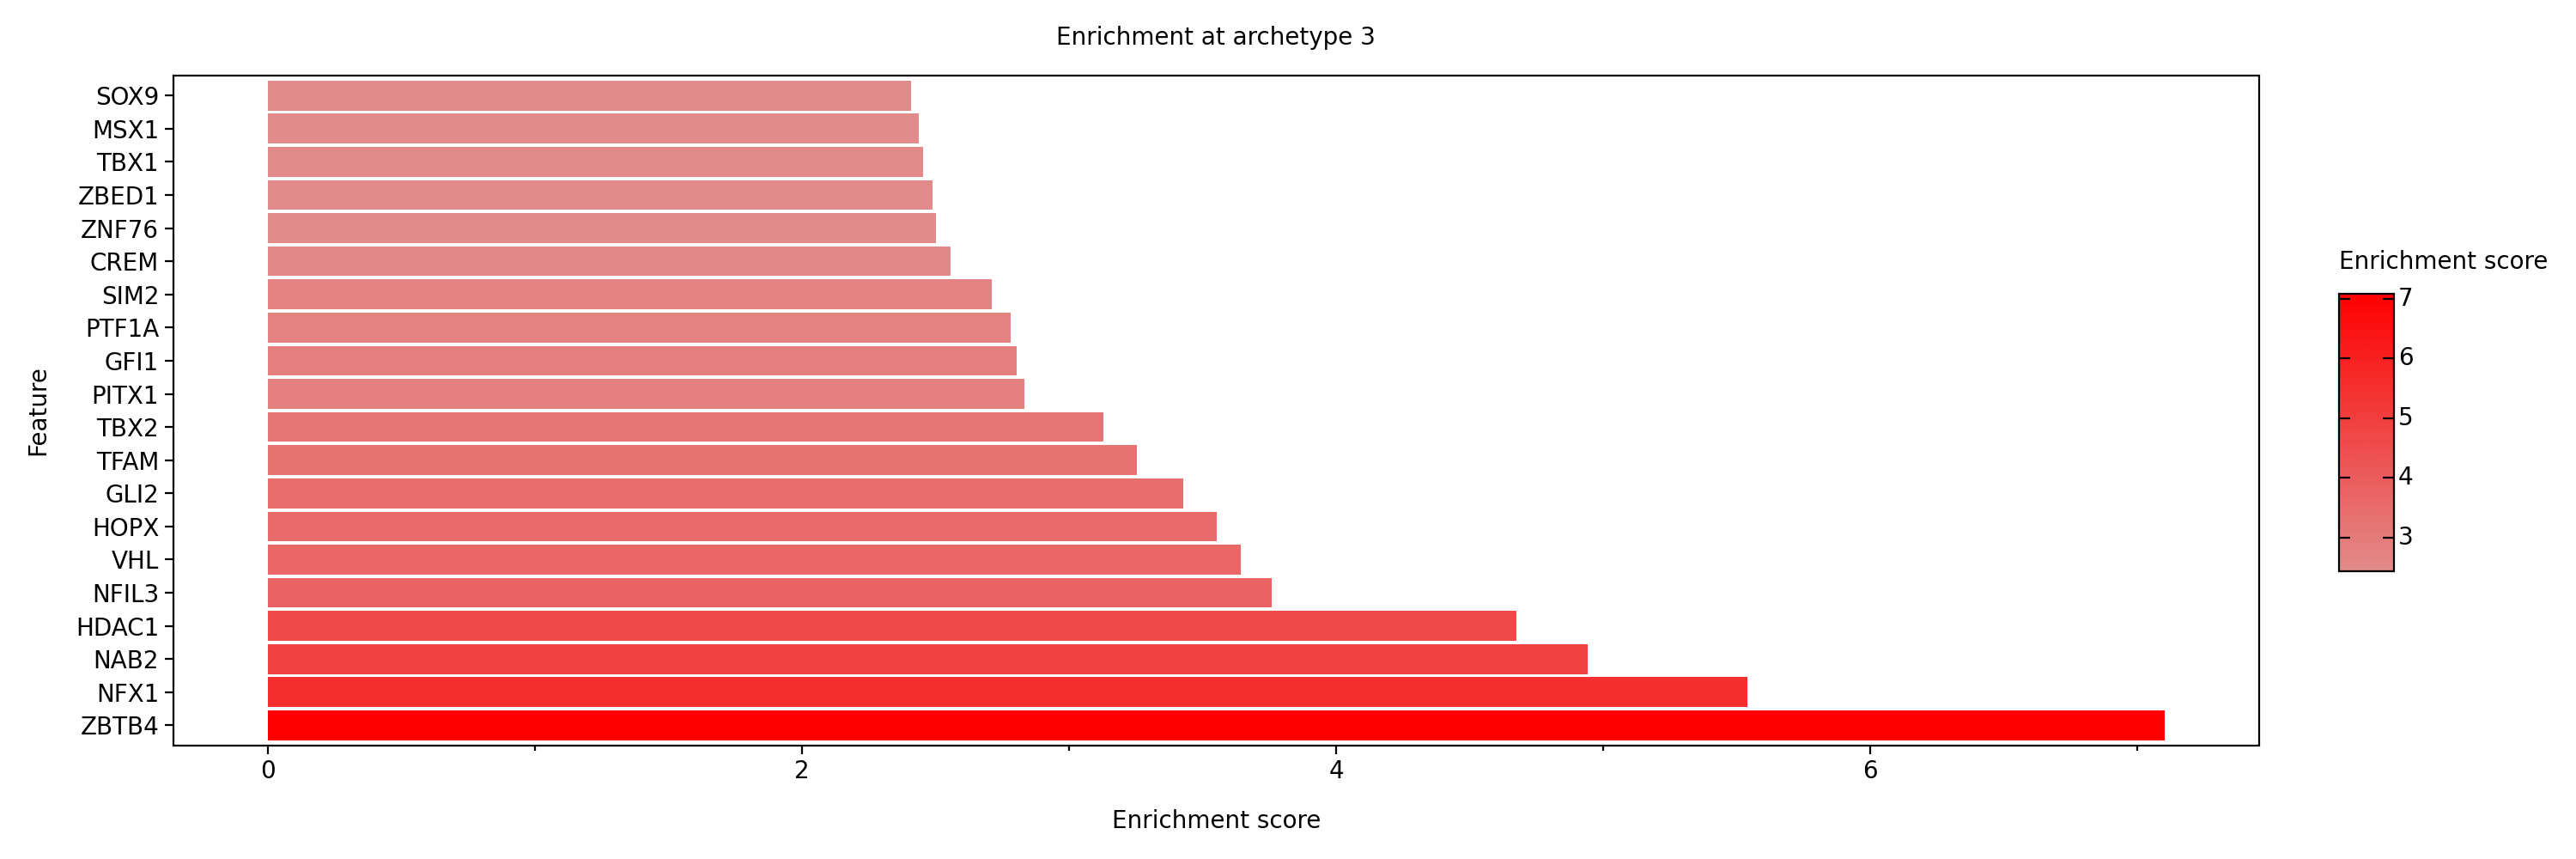

In [58]:
pt.barplot_functional_enrichment(top_processes_collectri)

Archetype 2 associtaed with flare:

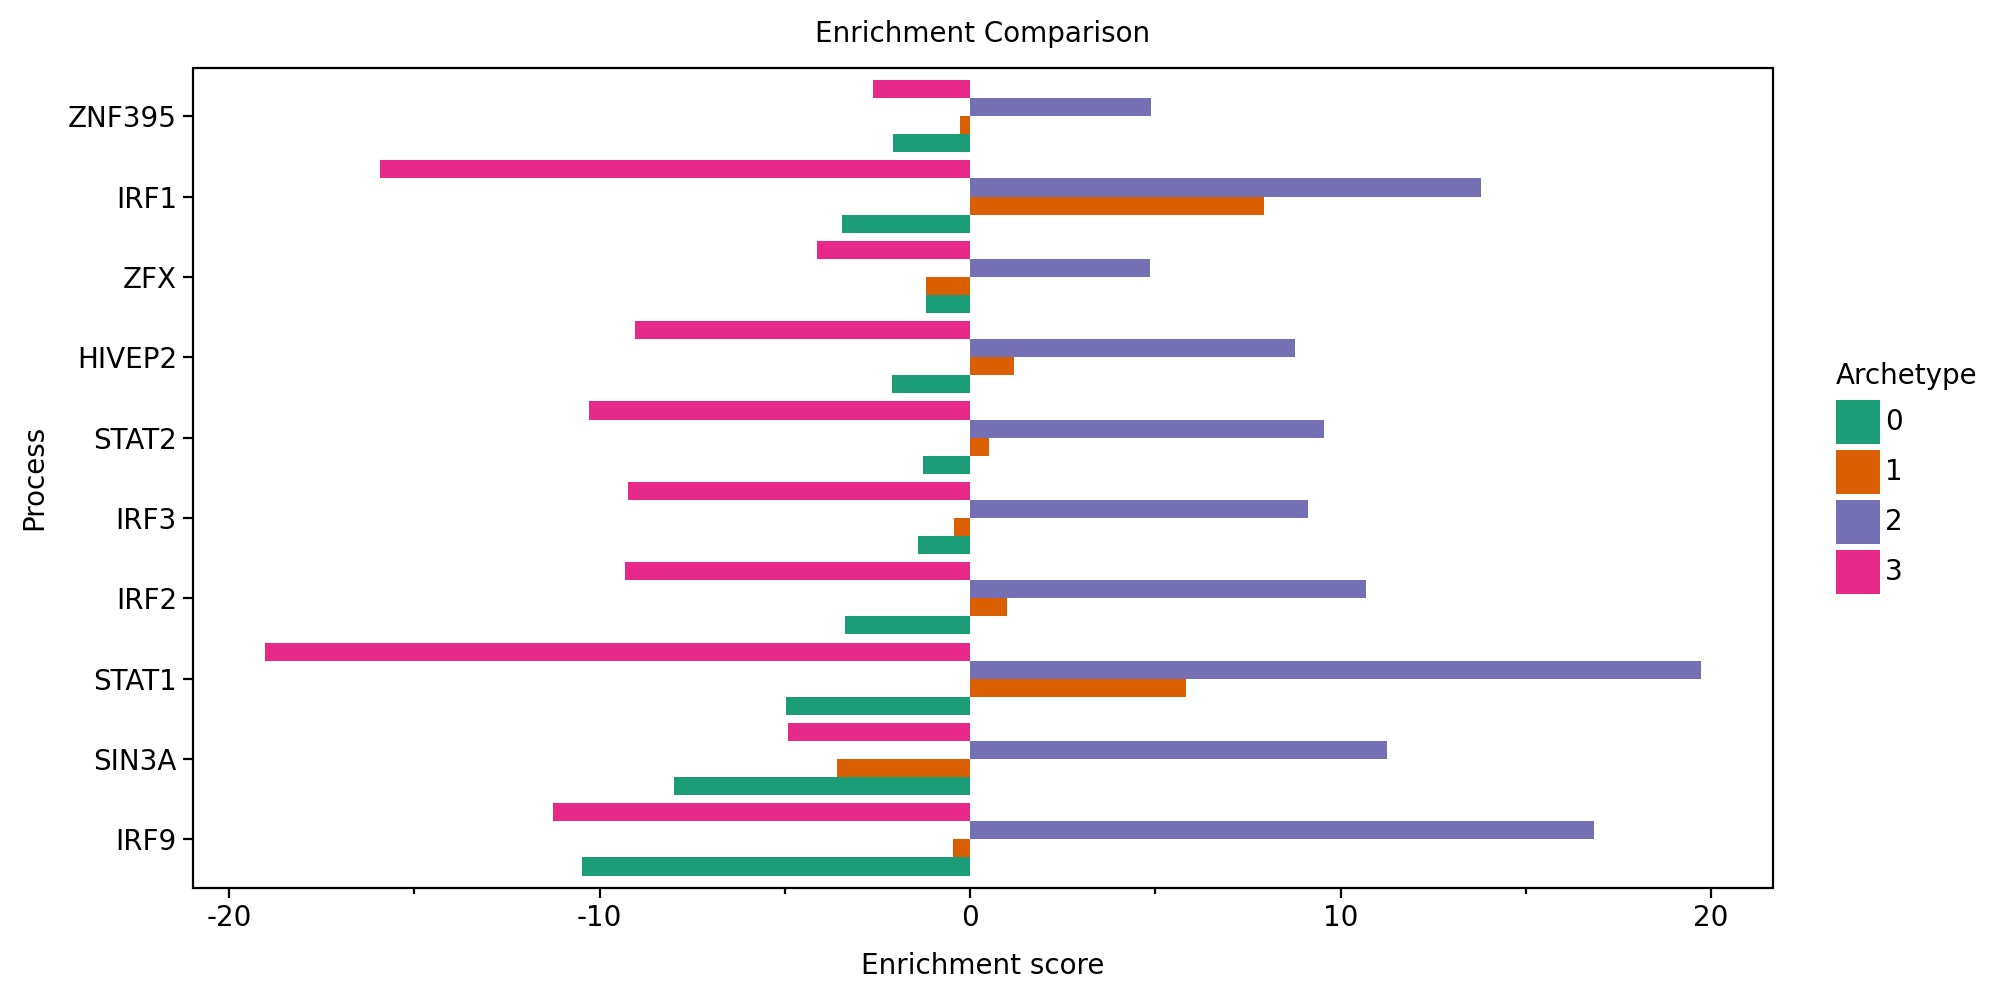

In [59]:
pt.barplot_enrichment_comparison(specific_processes_collectri[2])